In [42]:
import airfrans as af
import matplotlib.pyplot as plt

In [43]:
import tinycudann as tcnn

In [44]:
PATH_TO_DATASET = "/data/serrano/airfrans/Dataset/"

# 1. EDA

In [45]:
# to add to the dataset
# rescale the coordinates with a min-max
# 

In [46]:
import numpy as np

In [47]:
import torch

# 2. Try to fit a single image for each channel

In [48]:
import os
import sys
from pathlib import Path
sys.path.append("/home/serrano/Projects/INR_domain_decomposition/")

from src.data.dataset import GeometryDataset, KEY_TO_INDEX
from torch_geometric.loader import DataLoader

import einops
import json
import hydra
import numpy as np
import torch
import torch.nn as nn
import wandb
from coral.mlp import MLP, Derivative, ResNet
from omegaconf import DictConfig, OmegaConf
from torchdiffeq import odeint

from coral.losses import batch_mse_rel_fn
from coral.siren import ModulatedSiren
from coral.utils.data import (
    shape2coordinates,
    DatasetWithCode,
    set_seed,
)
from coral.utils.plot import show
from coral.utils.scheduler import learning_rate_scheduler
from graph_metalearning import outer_step

In [49]:
import yaml
from omegaconf import DictConfig

In [50]:
with open('../config/tinycuda.yaml', 'r') as f:
    cfg = yaml.safe_load(f)
cfg = DictConfig(cfg)

In [51]:
data_dir = cfg.data.dir
task = cfg.data.task
data_to_encode = cfg.data.data_to_encode
score = cfg.data.score
ntrain = cfg.data.ntrain
ntest = cfg.data.ntest
seed = cfg.data.seed

In [102]:
data_to_encode = 'nu'

In [103]:
data_dir = '/data/serrano/airfrans/'
print('data_dir', data_dir)

# train
with open(Path(data_dir) / 'Dataset/manifest.json', 'r') as f:
    manifest = json.load(f)

manifest_train = manifest[task + '_train']
testset = manifest[task + '_test'] if task != 'scarce' else manifest['full_test']
n = int(.9*len(manifest_train))

print("len manifest train", manifest_train, n)

trainset = manifest_train[:16] # was [:-n] ???
valset = manifest_train[-16:]

ntrain = len(trainset)
nval = len(valset)

data_dir /data/serrano/airfrans/
len manifest train ['airFoil2D_SST_36.622_11.319_3.941_5.424_1.0_16.283', 'airFoil2D_SST_58.831_-3.563_2.815_4.916_10.078', 'airFoil2D_SST_43.327_8.905_4.236_6.511_10.744', 'airFoil2D_SST_89.151_4.462_0.974_4.094_1.0_19.856', 'airFoil2D_SST_87.422_2.992_1.895_3.128_1.0_10.656', 'airFoil2D_SST_42.531_-3.927_1.264_6.838_0.0_7.489', 'airFoil2D_SST_46.246_9.78_3.769_2.353_17.745', 'airFoil2D_SST_67.481_-1.259_5.136_2.438_18.882', 'airFoil2D_SST_45.701_-1.925_0.671_7.455_0.0_12.285', 'airFoil2D_SST_85.488_6.826_3.112_3.445_1.0_17.471', 'airFoil2D_SST_56.177_2.108_1.208_3.592_0.0_14.763', 'airFoil2D_SST_46.0_-0.095_2.322_1.874_16.58', 'airFoil2D_SST_81.846_10.688_0.402_4.721_0.0_11.955', 'airFoil2D_SST_56.749_1.468_1.967_7.293_1.0_8.866', 'airFoil2D_SST_41.403_-2.446_1.908_4.316_0.0_5.008', 'airFoil2D_SST_44.858_13.36_1.546_3.174_1.0_10.604', 'airFoil2D_SST_71.85_7.865_2.88_6.646_0.0_18.137', 'airFoil2D_SST_90.26_10.644_0.076_3.962_1.0_18.874', 'airFoil2D_SST

In [104]:
#default sample is none
latent_dim = 128
batch_size = 16
trainset = GeometryDataset(trainset, key=data_to_encode, latent_dim=latent_dim, sample=None, norm=True, n_boot=16000)
print("loaded train")
valset = GeometryDataset(valset, key=data_to_encode, latent_dim=latent_dim, sample=None, n_boot=16000, coef_norm=trainset.coef_norm)

train_loader = DataLoader(trainset, batch_size=2, shuffle=True)
# test
val_loader = DataLoader(valset, batch_size=2, shuffle=True)
device = torch.device("cuda")

100%|████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.67it/s]


coef_norm (array([ 5.0193095e-01,  1.1042321e-02,  5.7883270e+01,  3.8414328e+00,
        2.3085196e-01, -1.6645475e-03, -7.8367477e-05], dtype=float32), array([ 0.7015379 ,  0.33686727, 17.840536  ,  5.4303937 ,  0.4738172 ,
        0.04192645,  0.06222026], dtype=float32), array([ 3.9744095e+01,  7.1306376e+00, -2.1624887e+02,  7.3773653e-04],
      dtype=float32), array([2.7370657e+01, 2.5211699e+01, 1.7900901e+03, 2.3892892e-03],
      dtype=float32))
loaded train


100%|████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.63it/s]

coef_norm (array([ 5.0193095e-01,  1.1042321e-02,  5.7883270e+01,  3.8414328e+00,
        2.3085196e-01, -1.6645475e-03, -7.8367477e-05], dtype=float32), array([ 0.7015379 ,  0.33686727, 17.840536  ,  5.4303937 ,  0.4738172 ,
        0.04192645,  0.06222026], dtype=float32), array([ 3.9744095e+01,  7.1306376e+00, -2.1624887e+02,  7.3773653e-04],
      dtype=float32), array([2.7370657e+01, 2.5211699e+01, 1.7900901e+03, 2.3892892e-03],
      dtype=float32))


In [15]:
xx = trainset.dataset[0].x

In [16]:
xx[..., 4].unique()

tensor([-0.4872, -0.4872, -0.4872,  ...,  6.9274,  6.9853,  6.9874])

# 1. Tiny cuda

# 1.1 Hash

In [105]:
epochs=5000

cfg.network.activation = "ReLU"
with open('../config/tiny/hash.yaml', 'r') as f:
    cfg = yaml.safe_load(f)
cfg = DictConfig(cfg)
cfg_dict = OmegaConf.to_container(cfg)
input_dim = 2
output_dim = 1

In [106]:
total_loss = 0
for graph, idx in train_loader:
    for k in range(len(graph)):
        mask = graph.batch == k
        coordinates = graph.pos[mask].cuda()
        images = graph.images[mask].cuda()

        nef = tcnn.NetworkWithInputEncoding(
            input_dim, output_dim,
            cfg_dict["encoding"], cfg_dict["network"]
        ).cuda()

        optimizer = torch.optim.Adam(nef.parameters(), lr=0.01)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, epochs //5, gamma=0.5)
    
        for step in range(epochs):
            mask = torch.randperm(coordinates.shape[0])[:4000]
            pred = nef(coordinates[mask])
            loss = ((pred - images[mask])**2).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            if step % 1000 == 0:
                print(f"loss: {((pred - images[mask])**2).mean()}")
        total_loss += loss.item()
total_loss = total_loss / batch_size

loss: 0.41834473609924316
loss: 0.003939303569495678
loss: 0.002858949126675725
loss: 0.0020471587777137756
loss: 0.0019211808685213327
loss: 2.599496603012085
loss: 0.027418849989771843
loss: 0.01615188643336296
loss: 0.014564711600542068
loss: 0.028585683554410934
loss: 0.1742212325334549
loss: 0.001292876317165792
loss: 0.000651926442515105
loss: 0.0004642611020244658
loss: 0.0003207185654900968
loss: 0.9173546433448792
loss: 0.012018457986414433
loss: 0.004621550906449556
loss: 0.003109666518867016
loss: 0.002421122742816806
loss: 0.2731333076953888
loss: 0.004250122234225273
loss: 0.002340350765734911
loss: 0.0017067360458895564
loss: 0.001743439701385796
loss: 0.5117878317832947
loss: 0.014315771870315075
loss: 0.0031909276731312275
loss: 0.004126016050577164
loss: 0.0028401832096278667
loss: 2.000018835067749
loss: 0.06673038005828857
loss: 0.020069753751158714
loss: 0.003408239921554923
loss: 0.003281619632616639
loss: 0.30101075768470764
loss: 0.0017433700850233436
loss: 0.001

In [107]:
print('total loss', total_loss)

total loss 0.003615778958192095


# 1.2 Dense

In [108]:
epochs=5000

cfg.network.activation = "ReLU"
with open('../config/tiny/dense.yaml', 'r') as f:
    cfg = yaml.safe_load(f)
cfg = DictConfig(cfg)
cfg_dict = OmegaConf.to_container(cfg)
input_dim = 2
output_dim = 1

In [109]:
total_loss = 0
for graph, idx in train_loader:
    for k in range(len(graph)):
        mask = graph.batch == k
        coordinates = graph.pos[mask].cuda()
        images = graph.images[mask].cuda()

        nef = tcnn.NetworkWithInputEncoding(
            input_dim, output_dim,
            cfg_dict["encoding"], cfg_dict["network"]
        ).cuda()

        optimizer = torch.optim.Adam(nef.parameters(), lr=0.01)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, epochs //5, gamma=0.5)
    
        for step in range(epochs):
            mask = torch.randperm(coordinates.shape[0])[:4000]
            pred = nef(coordinates[mask])
            loss = ((pred - images[mask])**2).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            if step % 1000 == 0:
                print(f"loss: {((pred - images[mask])**2).mean()}")
        total_loss += loss.item()
total_loss = total_loss / ntrain

loss: 0.19270138442516327
loss: 0.00027890398632735014
loss: 8.648893708596006e-05
loss: 6.172284338390455e-05
loss: 5.125892857904546e-05
loss: 0.6011102795600891
loss: 0.001261999597772956
loss: 0.0008316662278957665
loss: 0.0005070602055639029
loss: 0.00044388059177435935
loss: 0.2841934859752655
loss: 0.0002683911588974297
loss: 0.00010214768553851172
loss: 6.717591168126091e-05
loss: 6.290549208642915e-05
loss: 0.18132908642292023
loss: 0.00019690260523930192
loss: 0.00011962658754782751
loss: 5.6487151596229523e-05
loss: 5.02411785419099e-05
loss: 0.7784404754638672
loss: 0.0012031393125653267
loss: 0.0004440591437742114
loss: 0.0003368219477124512
loss: 0.0002722140634432435
loss: 2.7245333194732666
loss: 0.0017125289887189865
loss: 0.0007843701168894768
loss: 0.0006467347266152501
loss: 0.00045976886758580804
loss: 1.5668147802352905
loss: 0.0017847076524049044
loss: 0.0011588807683438063
loss: 0.0006433033267967403
loss: 0.0005370443104766309
loss: 2.1187734603881836
loss: 0.0

In [111]:
print('total loss', total_loss)

total loss 0.0002578887263098295


In [112]:
total_loss = 0
models = dict()

for graph, idx in train_loader:
    break
for k in range(2):
    mask = graph.batch == k
    coordinates = graph.pos[mask].cuda()
    images = graph.images[mask].cuda()
    
    nef = tcnn.NetworkWithInputEncoding(
        input_dim, output_dim,
        cfg_dict["encoding"], cfg_dict["network"]
    ).cuda()

    optimizer = torch.optim.Adam(nef.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, epochs //5, gamma=0.5)

    for step in range(epochs):
        mask = torch.randperm(coordinates.shape[0])[:18000]
        pred = nef(coordinates[mask])
        loss = ((pred - images[mask])**2).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        if step % 1000 == 0:
            print(f"loss: {((pred - images[mask])**2).mean()}")
    total_loss += loss.item()
    models[f"{k}"] = nef
total_loss = total_loss / 2

loss: 2.7609622478485107
loss: 0.0009799629915505648
loss: 0.0006653898162767291
loss: 0.0004394378047436476
loss: 0.00041757820872589946
loss: 0.8277363181114197
loss: 0.0004325819609221071
loss: 0.0003059702576138079
loss: 0.00016405945643782616
loss: 0.0001517020136816427


In [34]:
total_loss

0.002246894786367193

In [39]:
models['0'].params.shape

torch.Size([33376])

In [45]:
models['0'].parameters

<bound method Module.parameters of NetworkWithInputEncoding(n_input_dims=2, n_output_dims=1, seed=1337, dtype=torch.float16, hyperparams={'encoding': {'base_resolution': 8, 'hash': 'CoherentPrime', 'interpolation': 'Linear', 'n_features_per_level': 2, 'n_levels': 7, 'otype': 'Grid', 'per_level_scale': 1.5, 'type': 'Dense'}, 'network': {'activation': 'LeakyReLU', 'n_hidden_layers': 3, 'n_neurons': 32, 'otype': 'FullyFusedMLP', 'output_activation': 'None'}, 'otype': 'NetworkWithInputEncoding'})>

# 1.3 NeRF

In [118]:
epochs=5000

cfg.network.activation = "ReLU"
with open('../config/tiny/frequency.yaml', 'r') as f:
    cfg = yaml.safe_load(f)
cfg = DictConfig(cfg)
cfg_dict = OmegaConf.to_container(cfg)
input_dim = 2
output_dim = 1

In [119]:
total_loss = 0
for graph, idx in train_loader:
    for k in range(len(graph)):
        mask = graph.batch == k
        coordinates = graph.pos[mask].cuda()
        images = graph.images[mask].cuda()

        nef = tcnn.NetworkWithInputEncoding(
            input_dim, output_dim,
            cfg_dict["encoding"], cfg_dict["network"]
        ).cuda()

        optimizer = torch.optim.Adam(nef.parameters(), lr=0.01)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, epochs //5, gamma=0.5)
    
        for step in range(epochs):
            mask = torch.randperm(coordinates.shape[0])[:4000]
            pred = nef(coordinates[mask])
            loss = ((pred - images[mask])**2).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            if step % 1000 == 0:
                print(f"loss: {((pred - images[mask])**2).mean()}")
        total_loss += loss.item()
total_loss = total_loss / ntrain

loss: 0.5304308533668518
loss: 0.01178599614650011
loss: 0.013720768503844738
loss: 0.0014482763363048434
loss: 0.00795857235789299
loss: 0.27433347702026367
loss: 0.004724427592009306
loss: 0.00193119200412184
loss: 0.0009228454437106848
loss: 0.0018478903220966458
loss: 0.8577808141708374
loss: 0.013529598712921143
loss: 0.005738494917750359
loss: 0.004490042570978403
loss: 0.006955120246857405
loss: 1.8304023742675781
loss: 0.04016532376408577
loss: 0.02146366611123085
loss: 0.04040282592177391
loss: 0.006717971991747618
loss: 0.19024710357189178
loss: 0.004697498399764299
loss: 0.0006451316294260323
loss: 0.000501235481351614
loss: 0.000258921820204705
loss: 0.3903004229068756
loss: 0.0051322393119335175
loss: 0.0011206065537407994
loss: 0.0007047265535220504
loss: 0.0004157536895945668
loss: 2.8125603199005127
loss: 0.05436137691140175
loss: 0.01467096246778965
loss: 0.012343764305114746
loss: 0.008586439304053783
loss: 1.789184331893921
loss: 0.03176058828830719
loss: 0.015815244

In [122]:
print('pos embedding', total_loss)

pos embedding 0.004035291588479595


In [121]:
print('pos embedding', total_loss)

pos embedding 0.004035291588479595


In [124]:
pred = nef(coordinates).cpu().detach()
images = images.cpu().detach()

In [125]:
idx

tensor([14, 10])

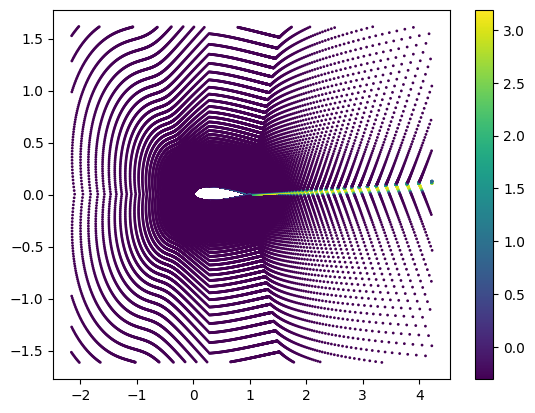

In [126]:
plt.scatter(coordinates[..., 0].cpu().detach(), coordinates[..., 1].cpu().detach(), c=images, s=1)
plt.colorbar()

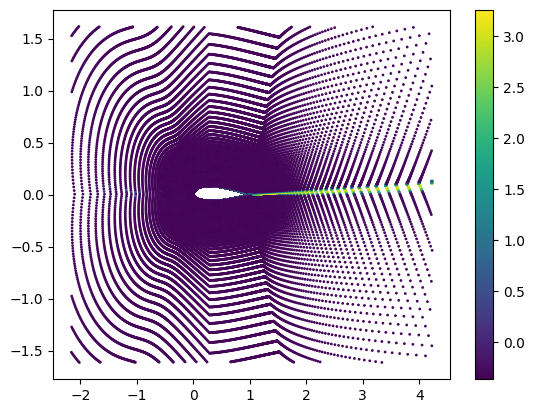

In [128]:
plt.scatter(coordinates[..., 0].cpu().detach(), coordinates[..., 1].cpu().detach(), c=pred, s=1)
plt.colorbar()

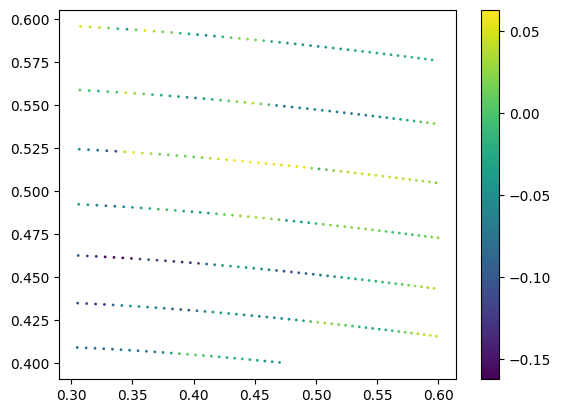

In [64]:
index = 1
mask2 = torch.logical_and(coordinates[..., 0] < 0.6, coordinates[..., 0] > 0.3)
mask3 = torch.logical_and(coordinates[..., 1] < 0.6, coordinates[..., 1] > 0.4)
mask = (mask2 & mask3).cpu()
plt.scatter(coordinates[mask, 0].cpu().detach(), coordinates[mask, 1].cpu().detach(), c=pred[mask], s=1)
plt.colorbar()

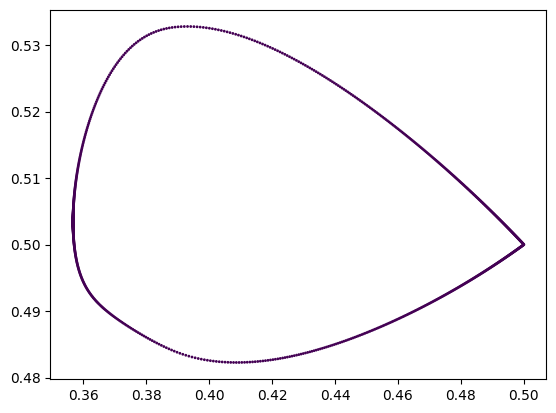

In [53]:
index = 1
mask1 = graph.batch == index
mask2 = graph.surface
plt.scatter(graph.pos[mask1&mask2, 0].cpu().detach(), graph.pos[mask1&mask2, 1].cpu().detach(), c=graph.images[mask1&mask2].cpu().detach(), s=1)

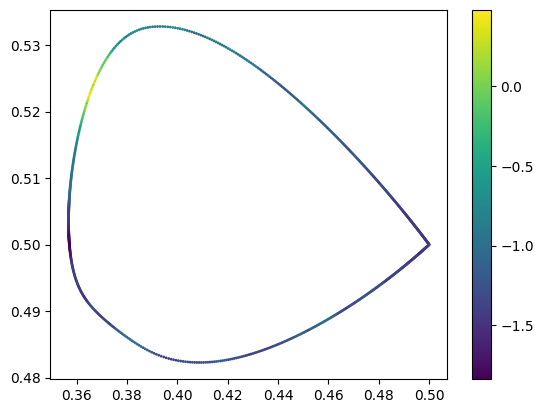

In [54]:
index = 1
mask1 = graph.batch == index
mask2 = graph.surface
pred = nef(graph.pos.cuda())
plt.scatter(graph.pos[mask1&mask2, 0].cpu().detach(), graph.pos[mask1&mask2, 1].cpu().detach(), c=pred[mask1&mask2].cpu().detach(), s=1)
plt.colorbar()

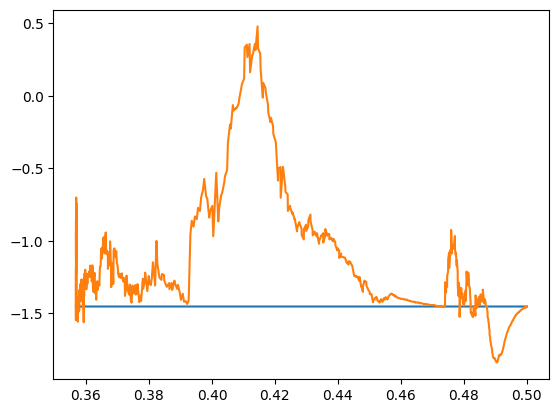

In [55]:
plt.plot(graph.pos[mask1&mask2, 0].cpu().detach().sort()[0],graph.images[mask1&mask2].cpu().detach())
plt.plot(graph.pos[mask1&mask2, 0].cpu().detach().sort()[0], pred[mask1&mask2].cpu().detach())

## 1.3.2 Include SDF

In [65]:
epochs=5000

cfg.network.activation = "ReLU"
with open('../config/tiny/frequency.yaml', 'r') as f:
    cfg = yaml.safe_load(f)
cfg = DictConfig(cfg)
cfg_dict = OmegaConf.to_container(cfg)
input_dim = 3
output_dim = 1

In [66]:
total_loss = 0
for graph, idx in train_loader:
    for k in range(len(graph)):
        mask = graph.batch == k
        coordinates = graph.pos[mask].cuda()
        sdf = graph.sdf[mask].cuda()
        images = graph.images[mask].cuda()

        nef = tcnn.NetworkWithInputEncoding(
            input_dim, output_dim,
            cfg_dict["encoding"], cfg_dict["network"]
        ).cuda()

        optimizer = torch.optim.Adam(nef.parameters(), lr=0.01)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, epochs //5, gamma=0.5)
    
        for step in range(epochs):
            mask = torch.randperm(coordinates.shape[0])[:4000]
            ipt = torch.cat([coordinates[mask], sdf[mask]], axis=-1)
            pred = nef(ipt)
            loss = ((pred - images[mask])**2).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            if step % 1000 == 0:
                print(f"loss: {((pred - images[mask])**2).mean()}")
        total_loss += loss.item()
total_loss = total_loss / ntrain

loss: 8.642332077026367
loss: 0.0099100973457098
loss: 0.0038591939955949783
loss: 0.000890539784450084
loss: 0.0009630392305552959
loss: 1.2532942295074463
loss: 0.0009742289548739791
loss: 0.0007490440038964152
loss: 0.0013170596212148666
loss: 0.0005001539248041809
loss: 0.1740923970937729
loss: 0.0005088354810141027
loss: 0.00013338489225134254
loss: 0.00010387786460341886
loss: 3.66595049854368e-05
loss: 0.13801781833171844
loss: 0.00025440414901822805
loss: 8.169956709025428e-05
loss: 7.147482392610982e-05
loss: 6.184884114190936e-05
loss: 0.16147862374782562
loss: 0.00020349900296423584
loss: 6.149466207716614e-05
loss: 5.8733690821100026e-05
loss: 4.873344369116239e-05
loss: 1.97623872756958
loss: 0.0017887483118101954
loss: 0.0005888240411877632
loss: 0.0002928034809883684
loss: 0.00021039180865045637
loss: 0.696736752986908
loss: 0.0005850670277141035
loss: 0.00018541929603088647
loss: 0.0003250648733228445
loss: 0.0001680243731243536
loss: 0.5557183027267456
loss: 0.00069386

In [67]:
print('pos embedding with sdf', total_loss)

pos embedding with sdf 0.0003340235672339986


In [18]:
print('pos embedding', total_loss)

pos embedding 0.0006375425591613748


In [68]:
pred = nef(torch.cat([coordinates, sdf], axis=-1)).cpu().detach()
images = images.cpu().detach()

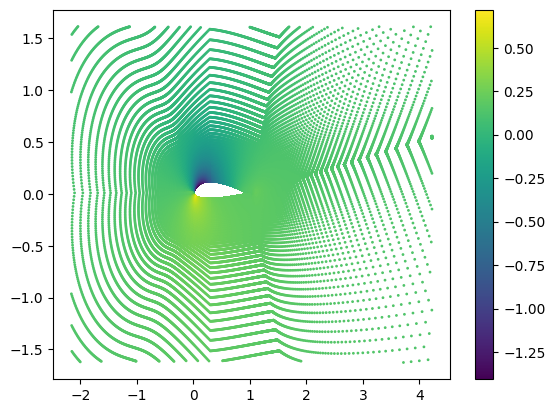

In [69]:
plt.scatter(coordinates[..., 0].cpu().detach(), coordinates[..., 1].cpu().detach(), c=images, s=1)
plt.colorbar()

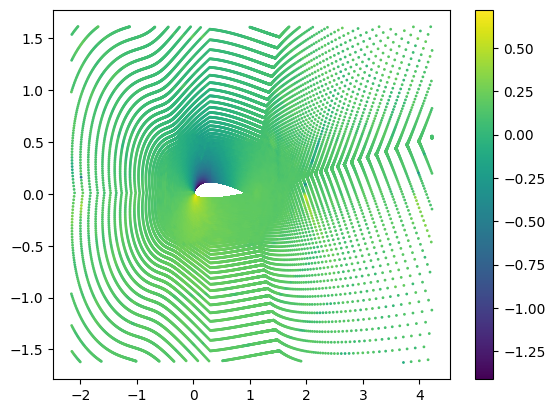

In [70]:
plt.scatter(coordinates[..., 0].cpu().detach(), coordinates[..., 1].cpu().detach(), c=pred, s=1)
plt.colorbar()

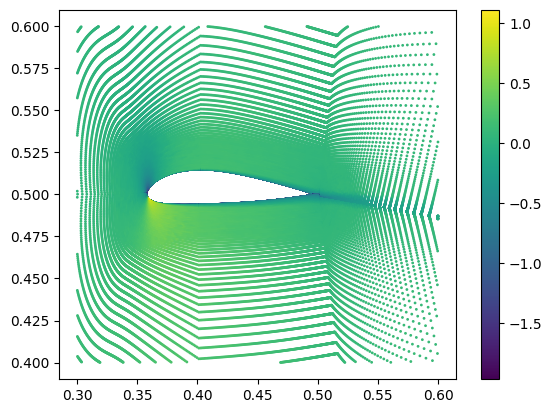

In [31]:
index = 1
mask2 = torch.logical_and(coordinates[..., 0] < 0.6, coordinates[..., 0] > 0.3)
mask3 = torch.logical_and(coordinates[..., 1] < 0.6, coordinates[..., 1] > 0.4)
mask = (mask2 & mask3).cpu()
plt.scatter(coordinates[mask, 0].cpu().detach(), coordinates[mask, 1].cpu().detach(), c=pred[mask], s=1)
plt.colorbar()

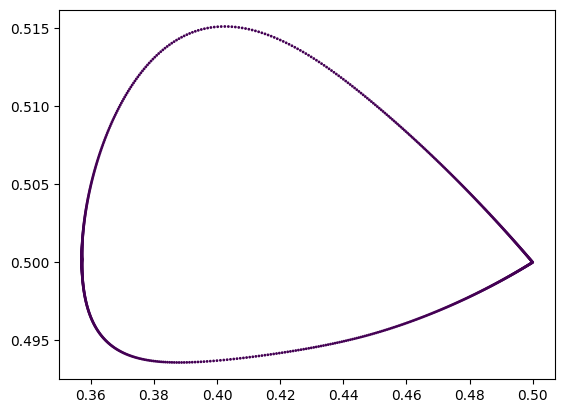

In [33]:
index = 1
mask1 = graph.batch == index
mask2 = graph.surface
plt.scatter(graph.pos[mask1&mask2, 0].cpu().detach(), graph.pos[mask1&mask2, 1].cpu().detach(), c=graph.images[mask1&mask2].cpu().detach(), s=1)

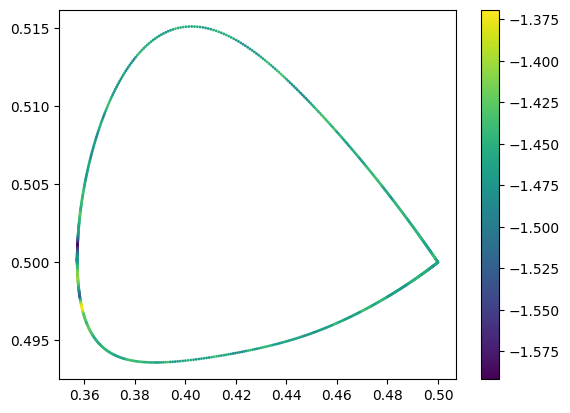

In [34]:
index = 1
mask1 = graph.batch == index
mask2 = graph.surface
ipt = torch.cat([graph.pos, graph.sdf.unsqueeze(-1)], axis=-1).cuda()
pred = nef(ipt)
plt.scatter(graph.pos[mask1&mask2, 0].cpu().detach(), graph.pos[mask1&mask2, 1].cpu().detach(), c=pred[mask1&mask2].cpu().detach(), s=1)
plt.colorbar()

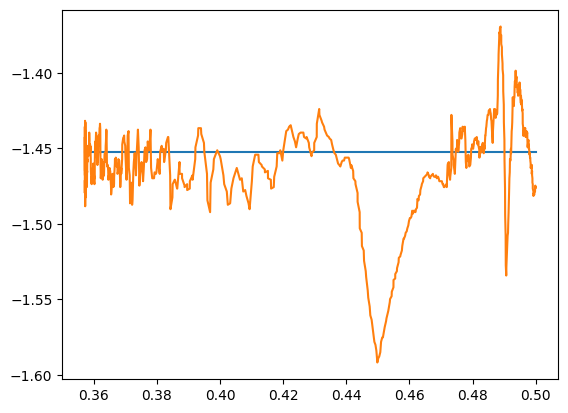

In [35]:
plt.plot(graph.pos[mask1&mask2, 0].cpu().detach().sort()[0],graph.images[mask1&mask2].cpu().detach())
plt.plot(graph.pos[mask1&mask2, 0].cpu().detach().sort()[0], pred[mask1&mask2].cpu().detach())

In [20]:
# one example

In [21]:
mask = graph.batch == k
coordinates = graph.pos[mask].cuda()
sdf = graph.sdf.unsqueeze(-1)[mask].cuda()
images = graph.images[mask].cuda()
input_dim = 2

nef = tcnn.NetworkWithInputEncoding(
    input_dim, output_dim,
    cfg_dict["encoding"], cfg_dict["network"]
).cuda()

epochs=10000
optimizer = torch.optim.Adam(nef.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, epochs //5, gamma=0.5)

for step in range(epochs):
    mask = torch.randperm(coordinates.shape[0])[:4000]
    #ipt = torch.cat([coordinates[mask], sdf[mask]], axis=-1)
    #pred = nef(ipt)
    pred = nef(coordinates[mask])
    loss = ((pred - images[mask])**2).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    if step % 1000 == 0:
        print(f"loss: {((pred - images[mask])**2).mean()}")

NameError: name 'graph' is not defined

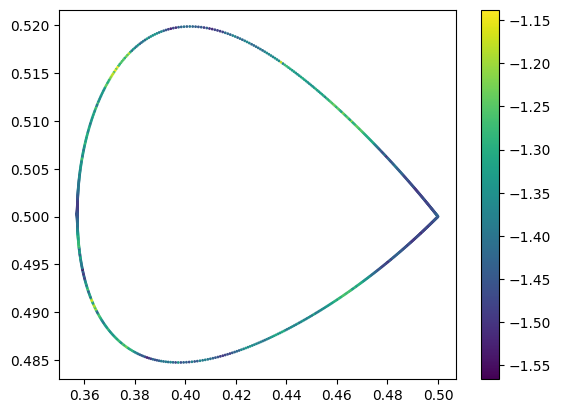

In [87]:
mask1 = graph.batch == k
mask2 = graph.surface
#ipt = torch.cat([graph.pos, graph.sdf.unsqueeze(-1)], axis=-1).cuda()
#pred = nef(ipt)
pred = nef(graph.pos.cuda())
plt.scatter(graph.pos[mask1&mask2, 0].cpu().detach(), graph.pos[mask1&mask2, 1].cpu().detach(), c=pred[mask1&mask2].cpu().detach(), s=1)
plt.colorbar()

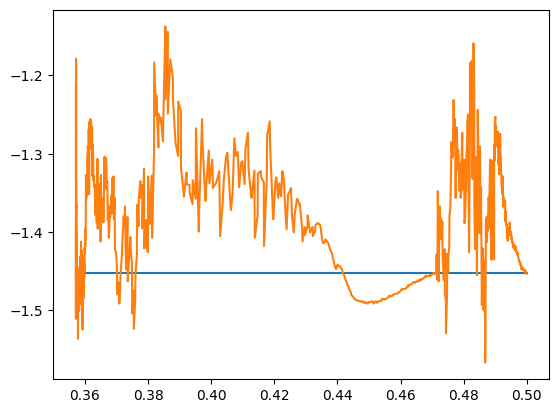

In [88]:
plt.plot(graph.pos[mask1&mask2, 0].cpu().detach().sort()[0],graph.images[mask1&mask2].cpu().detach())
plt.plot(graph.pos[mask1&mask2, 0].cpu().detach().sort()[0], pred[mask1&mask2].cpu().detach())

# 1.3.3 Include surface mesh sampling

In [109]:
mask = graph.batch == k
coordinates = graph.pos[mask].cuda()
sdf = graph.sdf.unsqueeze(-1)[mask].cuda()
surface = graph.surface[mask]
images = graph.images[mask].cuda()
input_dim = 2

nef = tcnn.NetworkWithInputEncoding(
    input_dim, output_dim,
    cfg_dict["encoding"], cfg_dict["network"]
).cuda()

epochs=15000
optimizer = torch.optim.Adam(nef.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, epochs //5, gamma=0.5)

for step in range(epochs):
    mask = torch.randperm(coordinates.shape[0])[:4000]
    mask = torch.cat([mask, torch.arange(surface.shape[0])[surface]])
    #ipt = torch.cat([coordinates[mask], sdf[mask]], axis=-1)
    #pred = nef(ipt)
    pred = nef(coordinates[mask])
    loss = ((pred - images[mask])**2).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    if step % 1000 == 0:
        print(f"loss: {((pred - images[mask])**2).mean()}")

loss: 0.5457301139831543
loss: 0.04755363240838051
loss: 0.03331296518445015
loss: 0.017794901505112648
loss: 0.010267452336847782
loss: 0.0069510373286902905
loss: 0.010167348198592663
loss: 0.0054834759794175625
loss: 0.011556640267372131
loss: 0.0029195903334766626
loss: 0.0018010939238592982
loss: 0.0011904435232281685
loss: 0.0025010849349200726
loss: 0.000738466449547559
loss: 0.00042504887096583843


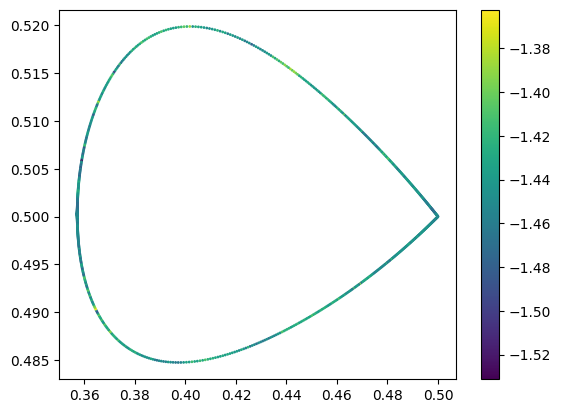

In [110]:
mask1 = graph.batch == k
mask2 = graph.surface
#ipt = torch.cat([graph.pos, graph.sdf.unsqueeze(-1)], axis=-1).cuda()
#pred = nef(ipt)
pred = nef(graph.pos.cuda())
plt.scatter(graph.pos[mask1&mask2, 0].cpu().detach(), graph.pos[mask1&mask2, 1].cpu().detach(), c=pred[mask1&mask2].cpu().detach(), s=1)
plt.colorbar()

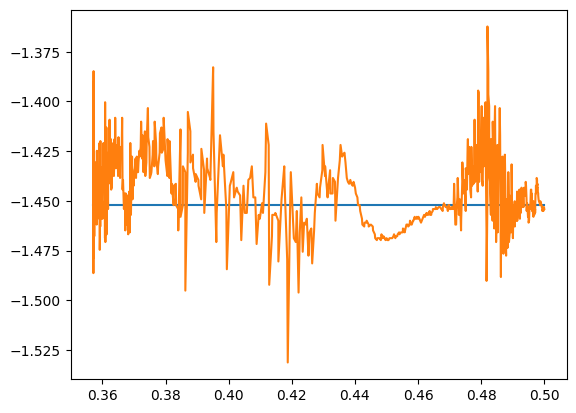

In [111]:
plt.plot(graph.pos[mask1&mask2, 0].cpu().detach().sort()[0],graph.images[mask1&mask2].cpu().detach())
plt.plot(graph.pos[mask1&mask2, 0].cpu().detach().sort()[0], pred[mask1&mask2].cpu().detach())

In [101]:
torch.arange(surface.shape[0])[surface]

tensor([   161,  24046,  24048,  ..., 138418, 138420, 138422])

In [102]:
surface[161]

tensor(True)

# 1.3.4 Gaussian positional embedding

In [1]:
from coral.mfn import FFPositionalEncoding

/data/serrano/miniconda3/tinycuda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
FFPositionalEncoding

In [180]:
class GaussianPositionalEmbedder(nn.Module):
    def __init__(self, input_dim=2, output_dim=1, width=256, depth=3, scale=5, with_input=False):
        super().__init__()
        self.embedding = FFPositionalEncoding(embedding_size=256, scale=scale, dims=2)
        #self.network = tcnn.Network(self.encoding.n_output_dims, output_dim, config["network"])
        self.with_input = with_input
        embed_dim = 256 + 2 if with_input else 256
        self.in_channels = [embed_dim] + [width]*(depth-1)
        self.out_channels = [width]*(depth-1) + [output_dim]
        self.layers = nn.ModuleList([nn.Linear(self.in_channels[k], self.out_channels[k]) for k in range(depth)])
        self.depth=depth
        self.hidden_dim = width

    def forward(self, x):
        pos = self.embedding(x)
        if self.with_input:
            x = torch.cat([pos, x], axis=-1)
        for k in range(len(self.layers)-1):
            x = torch.relu(self.layers[k](x))
        out = self.layers[-1](x)
        return out

In [ ]:
total_loss = 0
for graph, idx in train_loader:
    for k in range(len(graph)):
        mask = graph.batch == k
        coordinates = graph.pos[mask].cuda()
        images = graph.images[mask].cuda()
        epochs=5000

        nef = GaussianPositionalEmbedder(scale=5, with_input=True).cuda()

        optimizer = torch.optim.Adam(nef.parameters(), lr=0.01)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, epochs //5, gamma=0.5)
    
        for step in range(epochs):
            mask = torch.randperm(coordinates.shape[0])[:4000]
            pred = nef(coordinates[mask])
            loss = ((pred - images[mask])**2).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            if step % 1000 == 0:
                print(f"loss: {((pred - images[mask])**2).mean()}")
        total_loss += loss.item()
total_loss = total_loss / ntrain

loss: 0.365220844745636
loss: 0.0008548630867153406
loss: 0.00028641862445510924
loss: 0.00024182764173019677
loss: 0.00014284325879998505
loss: 2.8498575687408447
loss: 0.000692744564730674
loss: 0.0003876972768921405
loss: 0.00023149909975472838
loss: 0.00016896276792977005


In [179]:
print('nu gaussian fourier features, sigma=5', total_loss)

nu gaussian fourier features, sigma=5 0.00016062337567746


In [132]:
print('nu gaussian fourier features, sigma=1', total_loss)

nu gaussian fourier features, sigma=1 0.0004200774146738695


In [95]:
print('gaussian fourier features, sigma=1', total_loss)

gaussian fourier features, sigma=1 2.1632099404200744e-05


In [75]:
print('gaussian fourier features, sigma=10', total_loss)

gaussian fourier features 6.567788562961141e-05


In [143]:
mask = graph.batch == k
coordinates = graph.pos[mask].cuda()
images = graph.images[mask].cuda()
pred = nef(coordinates)

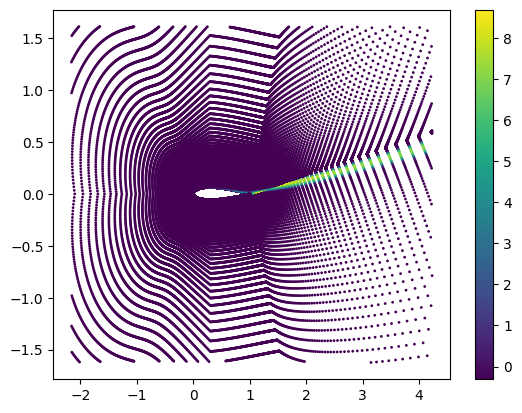

In [144]:
plt.scatter(coordinates[..., 0].cpu().detach(), coordinates[..., 1].cpu().detach(), c=images.cpu().detach(), s=1)
plt.colorbar()

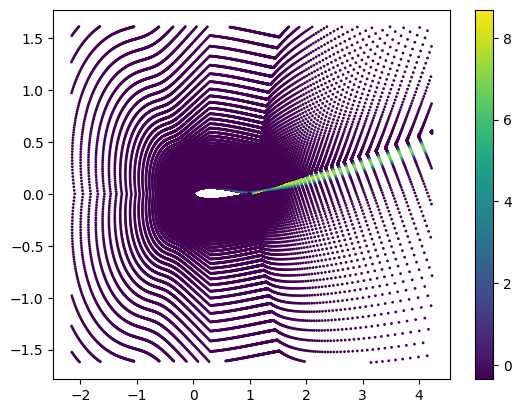

In [145]:
plt.scatter(coordinates[..., 0].cpu().detach(), coordinates[..., 1].cpu().detach(), c=pred.cpu().detach(), s=1)
plt.colorbar()

In [146]:
# with one sample
mask = graph.batch == 0
coordinates = graph.pos[mask].cuda()
sdf = graph.sdf.unsqueeze(-1)[mask].cuda()
surface = graph.surface[mask]
images = graph.images[mask].cuda()
input_dim = 2

nef = GaussianPositionalEmbedder(scale=1).cuda()

epochs=5000
optimizer = torch.optim.Adam(nef.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, epochs //5, gamma=0.5)

for step in range(epochs):
    mask = torch.randperm(coordinates.shape[0])[:4000]
    mask = torch.cat([mask, torch.arange(surface.shape[0])[surface]])
    #ipt = torch.cat([coordinates[mask], sdf[mask]], axis=-1)
    #pred = nef(ipt)
    pred = nef(coordinates[mask])
    loss = ((pred - images[mask])**2).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    if step % 1000 == 0:
        print(f"loss: {((pred - images[mask])**2).mean()}")

loss: 0.468831330537796
loss: 0.017618464305996895
loss: 0.0043853833340108395
loss: 0.002057156525552273
loss: 0.001330531551502645


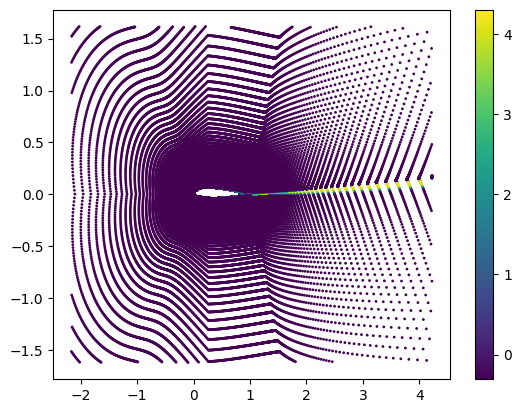

In [147]:
plt.scatter(coordinates[..., 0].cpu().detach(), coordinates[..., 1].cpu().detach(), c=images.cpu().detach(), s=1)
plt.colorbar()

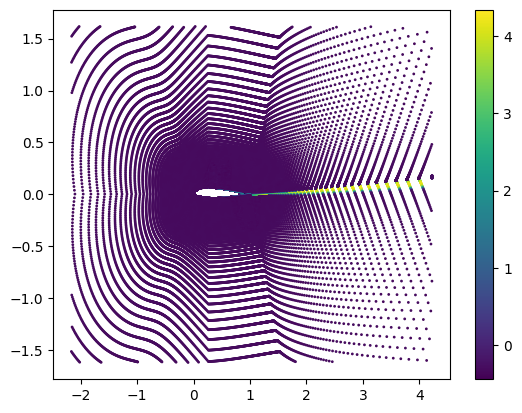

In [148]:
pred = nef(coordinates)
plt.scatter(coordinates[..., 0].cpu().detach(), coordinates[..., 1].cpu().detach(), c=pred.cpu().detach(), s=1)
plt.colorbar()

In [172]:
# 0.0028 avec scale=5
# 0.00088 avec scale=10

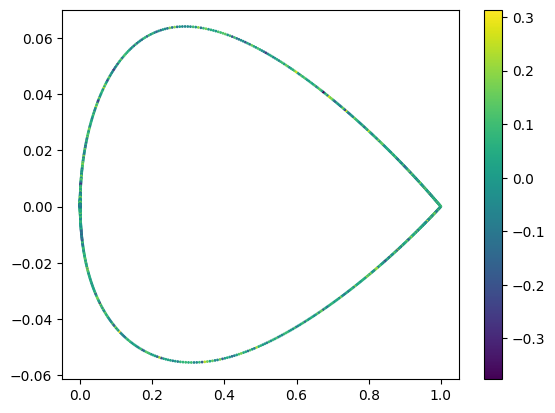

In [173]:
mask1 = graph.batch == k
mask2 = graph.surface
#ipt = torch.cat([graph.pos, graph.sdf.unsqueeze(-1)], axis=-1).cuda()
#pred = nef(ipt)
pred = nef(graph.pos.cuda())
plt.scatter(graph.pos[mask1&mask2, 0].cpu().detach(), graph.pos[mask1&mask2, 1].cpu().detach(), c=pred[mask1&mask2].cpu().detach(), s=1)
plt.colorbar()

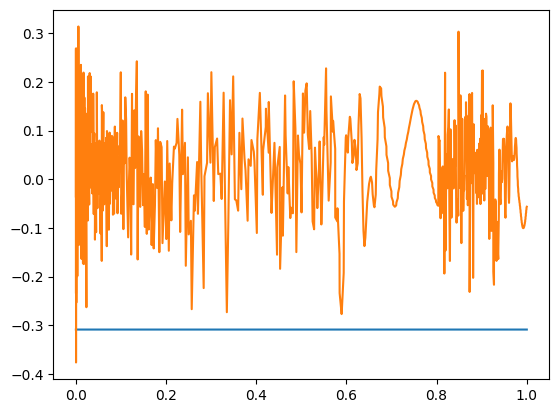

In [174]:
plt.plot(graph.pos[mask1&mask2, 0].cpu().detach().sort()[0],graph.images[mask1&mask2].cpu().detach())
plt.plot(graph.pos[mask1&mask2, 0].cpu().detach().sort()[0], pred[mask1&mask2].cpu().detach())

# 1.4 Siren 

In [149]:
from coral.siren import Siren

In [150]:
surface.sum()

tensor(1079)

In [171]:
mask = graph.batch == k
coordinates = graph.pos[mask].cuda()
sdf = graph.sdf.unsqueeze(-1)[mask].cuda()
surface = graph.surface[mask]
images = graph.images[mask].cuda()
input_dim = 2
gamma = 1

nef = Siren(dim_in=2,
    dim_hidden=256,
    dim_out=1,
    num_layers=3,
        w0=30.0,
        w0_initial=30.0,
        use_bias=True,).cuda()

epochs=15000
optimizer = torch.optim.Adam(nef.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, epochs //5, gamma=0.5)

for step in range(epochs):
    mask = torch.randperm(coordinates.shape[0])[:4000]
    mask = torch.cat([mask, torch.arange(surface.shape[0])[surface]])
    #ipt = torch.cat([coordinates[mask], sdf[mask]], axis=-1)
    #pred = nef(ipt)
    pred = nef(coordinates[mask])
#    print(step, pred.max(), pred.min(), pred.mean())
    loss = ((pred - images[mask]/gamma)**2).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    if step % 1000 == 0:
        print(f"loss: {((pred*gamma - images[mask])**2).mean()}")

loss: 1.389259934425354
loss: 1.4645390510559082
loss: 1.3530412912368774
loss: 1.492493748664856


KeyboardInterrupt: 

In [ ]:
images.min()

In [152]:
nef.last_layer.linear.weight.grad

tensor([[ 5.7833e-03,  4.6740e-03,  1.0744e-02,  1.1394e-02, -1.3732e-02,
          1.2006e-02, -1.2705e-02, -1.7612e-02,  1.4721e-02, -4.6128e-03,
          1.6229e-02, -6.7646e-03, -9.0297e-03,  1.3286e-02, -6.5280e-04,
         -1.1634e-02,  1.3365e-02, -1.3091e-02,  1.5331e-02,  6.3298e-03,
          1.2296e-02, -9.1237e-03,  1.3125e-02, -1.0900e-02,  7.5649e-04,
          1.5239e-02,  1.3522e-02,  1.2117e-02,  1.1204e-02, -2.4790e-03,
          3.0298e-03,  8.5828e-03,  9.5722e-03, -1.4480e-02,  2.5860e-03,
         -9.4756e-03, -8.8906e-03, -1.8378e-03, -4.2164e-03,  1.3197e-02,
         -1.5536e-02,  1.3244e-02, -1.1732e-02, -1.2052e-02, -1.4728e-02,
          8.8380e-03,  4.3233e-03, -7.0337e-03,  3.4995e-03, -1.6084e-02,
          6.4169e-03,  1.2816e-02,  1.2469e-02, -9.6090e-03, -4.2888e-04,
          1.3157e-02,  1.5053e-02,  1.4547e-02,  4.1540e-03, -1.3013e-02,
          1.1910e-02,  4.1062e-03,  1.3659e-02,  1.4290e-02, -7.1139e-03,
          7.4539e-03,  4.7781e-03, -3.

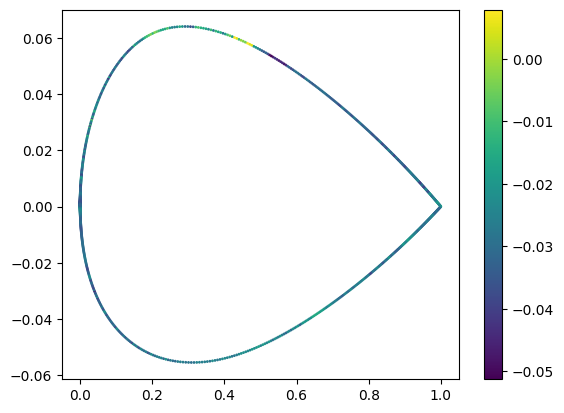

In [153]:
mask1 = graph.batch == k
mask2 = graph.surface
#ipt = torch.cat([graph.pos, graph.sdf.unsqueeze(-1)], axis=-1).cuda()
#pred = nef(ipt)
pred = nef(graph.pos.cuda())
plt.scatter(graph.pos[mask1&mask2, 0].cpu().detach(), graph.pos[mask1&mask2, 1].cpu().detach(), c=pred[mask1&mask2].cpu().detach(), s=1)
plt.colorbar()

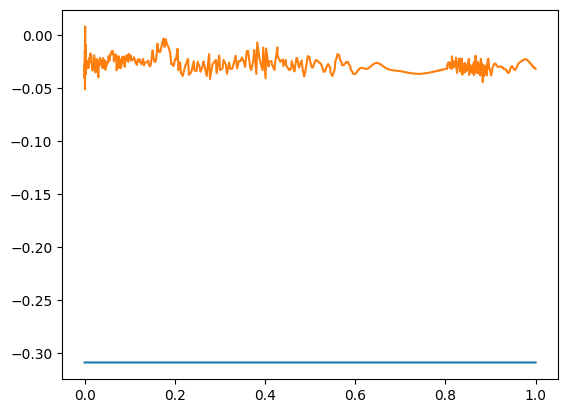

In [154]:
plt.plot(graph.pos[mask1&mask2, 0].cpu().detach().sort()[0],graph.images[mask1&mask2].cpu().detach())
plt.plot(graph.pos[mask1&mask2, 0].cpu().detach().sort()[0], pred[mask1&mask2].cpu().detach())

# 1.5 MFN

In [155]:
from coral.mfn import MFNBase

In [156]:
class FourierLayer(nn.Module):
    """
    Sine filter as used in FourierNet.
    """

    def __init__(self, in_features, out_features, weight_scale):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.linear.weight.data *= weight_scale  # gamma
        self.linear.bias.data.uniform_(-np.pi, np.pi)
        return

    def forward(self, x):
        return torch.sin(self.linear(x))


In [157]:
class FourierNetSimple(MFNBase):
    def __init__(
        self,
        in_size,
        hidden_size,
        out_size,
        n_layers=3,
        input_scale=256.0,
        weight_scale=1.0,
        bias=True,
        output_act=False,
    ):
        super().__init__(
            hidden_size, out_size, n_layers, weight_scale, bias, output_act
        )
        self.filters = nn.ModuleList(
            [
                FourierLayer(in_size, hidden_size, input_scale / np.sqrt(n_layers + 1))
                for _ in range(n_layers + 1)
            ]
        )

In [158]:
train_loader

In [159]:
mask = graph.batch == k
coordinates = graph.pos[mask].cuda()
sdf = graph.sdf.unsqueeze(-1)[mask].cuda()
surface = graph.surface[mask]
images = graph.images[mask].cuda()
input_dim = 2

nef = FourierNetSimple(in_size=2,
        hidden_size=128,
        out_size=1,
        n_layers=3,
        input_scale=256,
        weight_scale=1.0,
        bias=True,
        output_act=False,).cuda()

epochs=5000
optimizer = torch.optim.Adam(nef.parameters(), lr=0.03)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, epochs //5, gamma=0.5)

for step in range(epochs):
    mask = torch.randperm(coordinates.shape[0])[:4000]
    mask = torch.cat([mask, torch.arange(surface.shape[0])[surface]])
    #ipt = torch.cat([coordinates[mask], sdf[mask]], axis=-1)
    #pred = nef(ipt)
    pred = nef({"coords":coordinates[mask]})["model_out"]["output"]
    loss = ((pred - images[mask])**2).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    if step % 1000 == 0:
        print(f"loss: {((pred - images[mask])**2).mean()}")

loss: 2.112834930419922
loss: 0.020281614735722542
loss: 0.014015517197549343
loss: 0.012417948804795742
loss: 0.011258663609623909


# 1.6 Gabor net

In [160]:
from coral.mfn import GaborNet

In [162]:
mask = graph.batch == k
coordinates = graph.pos[mask].cuda()
sdf = graph.sdf.unsqueeze(-1)[mask].cuda()
surface = graph.surface[mask]
images = graph.images[mask].cuda()
input_dim = 2

nef = GaborNet(in_size=2,
        hidden_size=128,
        out_size=1,
        n_layers=3,
        input_scale=256,
        weight_scale=1.0,
        bias=True,
        output_act=False,).cuda()

epochs=5000
optimizer = torch.optim.Adam(nef.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, epochs //5, gamma=0.5)

for step in range(epochs):
    mask = torch.randperm(coordinates.shape[0])[:4000]
    mask = torch.cat([mask, torch.arange(surface.shape[0])[surface]])
    #ipt = torch.cat([coordinates[mask], sdf[mask]], axis=-1)
    #pred = nef(ipt)
    pred = nef({"coords":coordinates[mask]})["model_out"]["output"]
    loss = ((pred - images[mask])**2).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    if step % 1000 == 0:
        print(f"loss: {((pred - images[mask])**2).mean()}")

loss: 1.4504749774932861
loss: 0.005629637744277716
loss: 0.003985773306339979
loss: 0.0026969138998538256
loss: 0.0023686480708420277


In [163]:
# 1.6 SSN

In [166]:
class SSN(nn.Module):
    """SIREN model.

    Args:
        dim_in (int): Dimension of input.
        dim_hidden (int): Dimension of hidden layers.
        dim_out (int): Dimension of output.
        num_layers (int): Number of layers.
        w0 (float): Omega 0 from SIREN paper.
        w0_initial (float): Omega 0 for first layer.
        use_bias (bool): Whether to learn bias in linear layer.
    """

    def __init__(
        self,
        dim_in,
        dim_hidden,
        dim_out,
        num_layers,
        w0=30.0,
        w0_initial=30.0,
        use_bias=True,
    ):
        super().__init__()
        self.dim_in = dim_in
        self.dim_hidden = dim_hidden
        self.dim_out = dim_out
        self.num_layers = num_layers
        self.w0 = w0

        layers = [nn.Linear(dim_in, dim_hidden)]
        for j in range(self.num_layers-1):
            layers.append(nn.Linear(dim_hidden, dim_hidden))
        layers.append(nn.Linear(dim_hidden, dim_out))
        self.layers = nn.ModuleList(layers)
        
        self.init_weights()
                          
    def init_weights(self):
        for j, layer in enumerate(self.layers):
            if j == 0:
                nn.init.normal(layer.weight, 0,  np.sqrt(2) / np.sqrt(layer.weight.shape[1]))
                #nn.init.uniform(layer.weight, -self.w0 / layer.weight.shape[1], self.w0 / layer.weight.shape[1])
            else:
                nn.init.normal(layer.weight, 0, np.sqrt(2) / np.sqrt(layer.weight.shape[1]))
            print(layer.weight.std())
        
    def forward(self, x):
        for j, layer in enumerate(self.layers[:-1]):
            if j == 0:
                x = torch.sin(self.w0*layer(x))
            else:
                x = torch.sin(layer(x))
        out = self.layers[-1](x)
        return out 

In [169]:
mask = graph.batch == k
coordinates = graph.pos[mask].cuda()
sdf = graph.sdf.unsqueeze(-1)[mask].cuda()
surface = graph.surface[mask]
images = graph.images[mask].cuda()
input_dim = 2

nef = SSN(dim_in=2,
        dim_hidden=256,
        dim_out=1,
        num_layers=3,
        w0=50.0,
        w0_initial=30.0,
        use_bias=True,).cuda()

epochs=5000
optimizer = torch.optim.Adam(nef.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, epochs //5, gamma=0.5)

for step in range(epochs):
    mask = torch.randperm(coordinates.shape[0])[:4000]
    mask = torch.cat([mask, torch.arange(surface.shape[0])[surface]])
    #ipt = torch.cat([coordinates[mask], sdf[mask]], axis=-1)
    #pred = nef(ipt)
    pred = nef(coordinates[mask])
    loss = ((pred - images[mask])**2).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    if step % 1000 == 0:
        print(f"loss: {((pred - images[mask])**2).mean()}")

/tmp/ipykernel_558643/659419194.py:42: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(layer.weight, 0,  np.sqrt(2) / np.sqrt(layer.weight.shape[1]))
/tmp/ipykernel_558643/659419194.py:45: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(layer.weight, 0, np.sqrt(2) / np.sqrt(layer.weight.shape[1]))


tensor(1.0490, grad_fn=<StdBackward0>)
tensor(0.0882, grad_fn=<StdBackward0>)
tensor(0.0884, grad_fn=<StdBackward0>)
tensor(0.0844, grad_fn=<StdBackward0>)
loss: 1.8221385478973389
loss: 0.006504146847873926
loss: 0.0033083155285567045
loss: 0.0023808307014405727
loss: 0.002111224690452218


In [134]:
pred.shape

torch.Size([5025, 1])

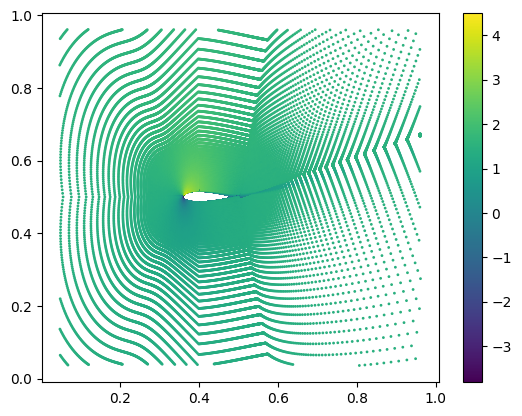

In [135]:
pred = nef(coordinates).cpu().detach()
plt.scatter(coordinates[..., 0].cpu().detach(), coordinates[..., 1].cpu().detach(), c=pred.detach().cpu(), s=1)
plt.colorbar()

In [139]:
nef.layers[-2].weight.grad

tensor([[ 4.9174e-05, -1.7011e-07,  6.5217e-05,  ..., -1.0203e-04,
          1.4166e-04,  5.5349e-05],
        [ 4.6527e-05,  4.2215e-05,  2.2840e-05,  ...,  1.6740e-06,
          2.9275e-05, -8.7583e-05],
        [-1.0688e-04, -1.3497e-04, -2.3925e-05,  ..., -2.2393e-05,
         -7.3225e-06,  2.4666e-04],
        ...,
        [-5.8961e-05,  4.3794e-05,  1.6263e-05,  ..., -1.6970e-04,
          1.2803e-04,  4.1764e-05],
        [-3.5665e-05, -1.8239e-04,  2.5197e-05,  ...,  3.0796e-05,
         -1.9864e-05,  1.8673e-04],
        [-1.3892e-04, -1.8165e-04, -6.2434e-05,  ..., -2.0915e-05,
          7.8126e-05,  1.4112e-04]], device='cuda:0')

# Try auto-decoding

In [154]:
cfg_dict['encoding']

{'otype': 'Grid',
 'type': 'Dense',
 'n_levels': 6,
 'n_features_per_level': 2,
 'log2_hashmap_size': 6,
 'base_resolution': 8,
 'per_level_scale': 1.5}

In [155]:
class ModulatedDecoder(nn.Module):
    def __init__(self, input_dim, output_dim, config, latent_dim=64, modulate_scale=False, modulate_shift=True):
        super().__init__()
        self.encoding = tcnn.Encoding(input_dim, config["encoding"], dtype=torch.float)
        self.frequency = tcnn.Encoding(input_dim, {"otype": "Frequency", "n_frequencies": 4 }, dtype=torch.float)
        self.network = tcnn.Network(self.encoding.n_output_dims + self.frequency.n_output_dims, 32, config["network"])

    def forward(self, x, instance_decoder):
        position = torch.cat([self.encoding(x), self.frequency(x)], axis=-1)
        out = self.network(position)
        out = instance_decoder(out)
        return out


In [208]:
class ModulatedTinyCuda(nn.Module):
    def __init__(self, input_dim, output_dim, config, latent_dim=64, modulate_scale=False, modulate_shift=True):
        super().__init__()
        self.encoding = tcnn.Encoding(input_dim, config["encoding"], dtype=torch.float)
        self.frequency = tcnn.Encoding(input_dim, {"otype": "Frequency", "n_frequencies": 8}, dtype=torch.float)
        mlp_config = {"otype": "CutlassMLP",     
         "activation": "None",      
        "output_activation": "ReLU", "n_neurons": 64, "n_hidden_layers": 0}
        
        mlp_config_out = {"otype": "CutlassMLP",     
         "activation": "None",      
        "output_activation": "None", "n_neurons": 64, "n_hidden_layers": 0}
        
        self.network1 = tcnn.Network(self.encoding.n_output_dims, 64, mlp_config)
        self.network2 = tcnn.Network(64, 64, mlp_config)
        self.network3 = tcnn.Network(64, 64, mlp_config)
        self.network4 = tcnn.Network(64, 64, mlp_config)
        self.network5 = tcnn.Network(64, 64, mlp_config)
        self.network6 = tcnn.Network(64, output_dim, mlp_config_out)
        
        self.bias1 = nn.Parameter(torch.zeros(64))
        self.bias2 = nn.Parameter(torch.zeros(64))
        self.bias3 = nn.Parameter(torch.zeros(64))
        self.bias4 = nn.Parameter(torch.zeros(64))
        self.bias5 = nn.Parameter(torch.zeros(64))
        self.bias6 = nn.Parameter(torch.zeros(1))
        
        self.latent_to_modulation = tcnn.Network(8, 5*64, config["network"])
        

    def forward(self, x, instance_encoder):
        modulations = self.latent_to_modulation(instance_encoder(x)).reshape(-1, 64, 5)
        #position = self.frequency(x)
        position = self.encoding(x)
        #x = (1 + modulations[..., 0, 0] ) * self.network1(position) + modulations[..., 0, 1]  
        #x = (1 + modulations[..., 1, 0] ) * self.network2(x) + modulations[..., 1, 1]
        #x = (1 + modulations[..., 2, 0] ) * self.network3(x) + modulations[..., 2, 1]
        x = self.network1(position) + modulations[..., 0] + self.bias1
        x = self.network2(x) + modulations[..., 1] + self.bias2
        x = self.network3(x) + modulations[..., 2] + self.bias3
        x = self.network4(x) + modulations[..., 3] + self.bias4
        x = self.network5(x) + modulations[..., 4] + self.bias5
        out = self.network6(x) + self.bias6
        return out


In [196]:
class ModulatedBigCuda(nn.Module):
    def __init__(self, input_dim, output_dim, config, latent_dim=64, modulate_scale=False, modulate_shift=True):
        super().__init__()
        enc_dict = config["encoding"].copy()
        enc_dict['n_features_per_level'] = 2
        enc_dict['n_levels'] = 8
        enc_dict['log2_hashmap_size'] = 14
        self.encoding = tcnn.Encoding(input_dim, enc_dict, dtype=torch.float)
        self.network = tcnn.Network(self.encoding.n_output_dims, output_dim, config["network"])
        
        mlp_config = {"otype": "CutlassMLP",     
         "activation": "None",      
        "output_activation": "None", "n_neurons": self.encoding.n_output_dims, "n_hidden_layers": 0}
        
        self.latent_to_modulation = tcnn.Network(12, self.encoding.n_output_dims, mlp_config)
        #nn.Linear(8, self.encoding.n_output_dims)

    def forward(self, x, instance_encoder):
        position = self.encoding(x) + self.latent_to_modulation(instance_encoder(x))
        #position = instance_encoder(x)
        out = self.network(position)
        return out

In [197]:
class ModulatedBigBigCuda(nn.Module):
    def __init__(self, input_dim, output_dim, config, latent_dim=64, modulate_scale=False, modulate_shift=True):
        super().__init__()
        enc_dict = config["encoding"].copy()
        enc_dict['n_features_per_level'] = 8
        enc_dict['n_levels'] = 8
        enc_dict['log2_hashmap_size'] = 14
        self.encoding1 = tcnn.Encoding(input_dim, enc_dict, dtype=torch.float)
        self.encoding2 = tcnn.Encoding(input_dim, enc_dict, dtype=torch.float)
        self.encoding3 = tcnn.Encoding(input_dim, enc_dict, dtype=torch.float)
        self.encoding4 = tcnn.Encoding(input_dim, enc_dict, dtype=torch.float)
        
        self.network = tcnn.Network(4*self.encoding1.n_output_dims, output_dim, config["network"])
        
        mlp_config = {"otype": "CutlassMLP",     
         "activation": "None",      
        "output_activation": "None", "n_neurons": self.encoding1.n_output_dims, "n_hidden_layers": 0}
        
        self.latent_to_modulation = tcnn.Network(12, 4*self.encoding1.n_output_dims, mlp_config)
        #nn.Linear(8, self.encoding.n_output_dims)

    def forward(self, x, instance_encoder):
        position = torch.cat([self.encoding1(x),
                              self.encoding2(x),
                              self.encoding3(x),
                              self.encoding4(x)], axis=-1)
        position = position + self.latent_to_modulation(instance_encoder(x))
        #position = instance_encoder(x)
        out = self.network(position)
        return out


In [162]:
with open('../config/tinycuda.yaml', 'r') as f:
    cfg = yaml.safe_load(f)
cfg = DictConfig(cfg)
cfg_dict = OmegaConf.to_container(cfg)

In [163]:
tinymodel = ModulatedTinyCuda(2, 1, cfg_dict).cuda()
optimizer = torch.optim.Adam(tinymodel.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, epochs // 5, gamma=0.5)

In [274]:
encoding_list = [tcnn.Encoding(2, cfg_dict["encoding"]).cuda() for k in range(ntrain)]

In [275]:
import itertools

In [276]:
code_optimizer = torch.optim.Adam(itertools.chain(*[enc.parameters() for enc in encoding_list]), lr=1e-3)

In [277]:
for step in range(10000):
    train_loss = 0
    for graph, idx in train_loader:
        coordinates = graph.pos.cuda()
        images = graph.images.cuda()
        code_optimizer.zero_grad()
        n_samples = len(graph)
        
        for sample in idx:
            crds = coordinates[graph.batch == sample]
            img = images[graph.batch == sample]
            mask = torch.randperm(crds.shape[0])[:18000]
            crds = crds[mask]
            img = img[mask]
        
            pred = tinymodel(crds, encoding_list[sample])
            loss = ((pred-img)**2).mean()
            loss.backward()
            train_loss += loss.item()                     
        code_optimizer.step()
                             
    optimizer.step()
    optimizer.zero_grad()
    
    if step%100==0:
        print('train_loss', train_loss / ntrain)
    
    scheduler.step()

train_loss 0.9952403903007507
train_loss 0.8923378586769104
train_loss 0.7858007252216339
train_loss 0.6818812191486359
train_loss 0.6290302574634552
train_loss 0.5903408527374268
train_loss 0.5612855702638626
train_loss 0.5600047260522842
train_loss 0.5442007035017014
train_loss 0.5239408612251282
train_loss 0.5544175803661346
train_loss 0.544961005449295
train_loss 0.5516579151153564
train_loss 0.5243181437253952
train_loss 0.5320151746273041
train_loss 0.5246268659830093
train_loss 0.5356601625680923
train_loss 0.5218006372451782
train_loss 0.5257488340139389
train_loss 0.5180391073226929
train_loss 0.5109315663576126
train_loss 0.5280763804912567
train_loss 0.5159168988466263
train_loss 0.5248792320489883
train_loss 0.525217741727829
train_loss 0.5171073079109192
train_loss 0.5323787182569504
train_loss 0.4957311153411865
train_loss 0.5086396932601929
train_loss 0.5229227393865585
train_loss 0.4952071011066437
train_loss 0.4894024580717087
train_loss 0.5275470167398453
train_loss 0

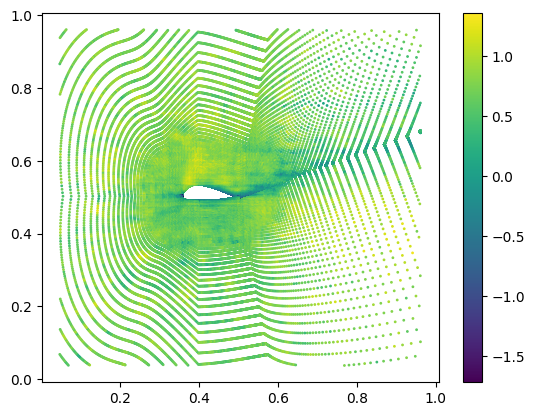

In [278]:
kk= 0
coordinates = graph.pos[graph.batch==kk]
pred = tinymodel(graph.pos[graph.batch==kk].cuda(), encoding_list[kk])
plt.scatter(coordinates[..., 0].detach().cpu(), coordinates[..., 1].detach().cpu(), c=pred.cpu().detach(), s=1)
plt.colorbar()

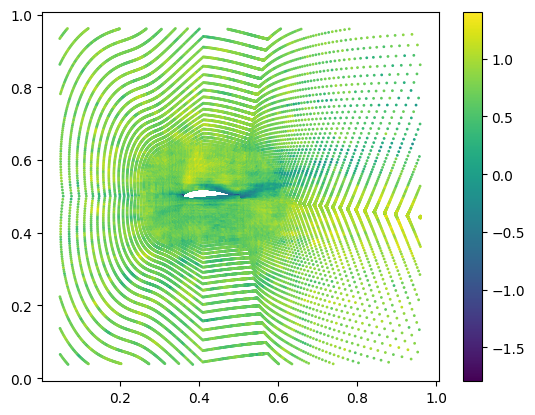

In [279]:
kk= 1
coordinates = graph.pos[graph.batch==kk]
pred = tinymodel(graph.pos[graph.batch==kk].cuda(), encoding_list[kk])
plt.scatter(coordinates[..., 0].detach().cpu(), coordinates[..., 1].detach().cpu(), c=pred.cpu().detach(), s=1)
plt.colorbar()

In [174]:
train_loss/ntrain

0.41150604337453844

In [133]:
code_optimizer.param_groups[0]['params'][0].dtype

torch.float32

In [134]:
pred.dtype

torch.float16

In [198]:
def zero_out_params(enc_list):
    for k in range(len(enc_list)):
        enc_list[k].params = nn.Parameter(torch.zeros_like(enc_list[k].params))
    return enc_list

In [199]:
from collections import OrderedDict
from functools import partial

import einops
import coral.losses as losses
import torch
import torch.nn as nn
import torch.utils.checkpoint as cp
from torch import autograd
from torch.nn.parallel import DistributedDataParallel as DDP


def inner_loop(
    func_rep,
    encoding_list,
    coordinates,
    features,
    batch_index,
    n_samples,
    inner_steps,
    inner_lr,
    is_train=False,
    gradient_checkpointing=False,
    loss_type="mse",
):
    """Performs inner loop, i.e. fits modulations such that the function
    representation can match the target features.

    Args:
        func_rep (models.ModulatedSiren):
        modulations (torch.Tensor): Shape (batch_size, latent_dim).
        coordinates (torch.Tensor): Coordinates at which function representation
            should be evaluated. Shape (batch_size, *, coordinate_dim).
        features (torch.Tensor): Target features for model to match. Shape
            (batch_size, *, feature_dim).
        inner_steps (int): Number of inner loop steps to take.
        inner_lr (float): Learning rate for inner loop.
        is_train (bool):
        gradient_checkpointing (bool): If True uses gradient checkpointing. This
            can massively reduce memory consumption.
    """
    inner_sgd = torch.optim.Adam(itertools.chain(*[enc.parameters() for enc in encoding_list]), lr=inner_lr)
    
    for step in range(inner_steps):
        if gradient_checkpointing:
            encoding_list = cp.checkpoint(
                inner_loop_step,
                func_rep,
                encoding_list,
                coordinates,
                features,
                inner_sgd,
                torch.as_tensor(is_train),
                torch.as_tensor(gradient_checkpointing),
                loss_type,
            )
        else:
            encoding_list = inner_loop_step(
                func_rep,
                encoding_list,
                coordinates,
                features,
                batch_index,
                n_samples,
                inner_sgd,
                is_train,
                gradient_checkpointing,
                loss_type,
            )
    return encoding_list


def inner_loop_step(
    func_rep,
    encoding_list,
    coordinates,
    features,
    batch_index,
    n_samples,
    inner_sgd,
    is_train=False,
    gradient_checkpointing=False,
    loss_type="mse",
):
    """Performs a single inner loop step."""
    detach = not torch.is_grad_enabled() and gradient_checkpointing

    if loss_type == "mse":
        element_loss_fn = losses.per_element_mse_fn
    elif loss_type == "bce":
        element_loss_fn = losses.per_element_nll_fn
    elif "multiscale" in loss_type:
        loss_name = loss_type.split("-")[1]
        element_loss_fn = partial(
            losses.per_element_multi_scale_fn,
            loss_name=loss_name,
            last_element=False,
        )

    with torch.enable_grad():
        # Note we multiply by batch size here to undo the averaging across batch
        # elements from the MSE function. Indeed, each set of modulations is fit
        # independently and the size of the gradient should not depend on how
        # many elements are in the batch
        loss = 0
        for k in range(len(encoding_list)):
            crds = coordinates[batch_index==k]
            feats = features[batch_index==k]
            mask = torch.randperm(crds.shape[0])[:18000]
            features_recon = func_rep(crds[mask], encoding_list[k])
            loss += ((features_recon - feats[mask])**2).mean()    # f
        
        loss.backward(retain_graph=True)
        inner_sgd.step()
        # if clip_grad_value is not None:
        #    nn.utils.clip_grad_value_(grad, clip_grad_value)
    # Perform single gradient descent step
    
    return encoding_list


def outer_step(
    func_rep,
    graph,
    encoding_list,
    inner_steps,
    inner_lr,
    is_train=False,
    return_reconstructions=False,
    gradient_checkpointing=False,
    loss_type="mse",
    use_rel_loss=False,
):
    """

    Args:
        coordinates (torch.Tensor): Shape (batch_size, *, coordinate_dim). Note this
            _must_ have a batch dimension.
        features (torch.Tensor): Shape (batch_size, *, feature_dim). Note this _must_
            have a batch dimension.
    """

    if loss_type == "mse":
        loss_fn = torch.nn.MSELoss()
    elif loss_type == "bce":
        loss_fn = torch.nn.BCEWithLogitsLoss()
    func_rep.zero_grad()
    if isinstance(func_rep, DDP):
        func_rep = func_rep.module

    n_samples = len(graph)
    batch_index = graph.batch
    features = graph.images.clone()
    coordinates = graph.pos.clone()
    
    encoding_list = zero_out_params(encoding_list)

    # Run inner loop
    encoding_list = inner_loop(
        func_rep,
        encoding_list,
        coordinates,
        features,
        batch_index,
        n_samples,
        inner_steps,
        inner_lr,
        is_train,
        gradient_checkpointing,
        loss_type,
    )
    per_example_loss = 0
    with torch.set_grad_enabled(is_train):
        for k in range(len(encoding_list)):
            crds = coordinates[graph.batch==k]
            feats = features[graph.batch==k]
            mask = torch.randperm(crds.shape[0])[:18000]
            features_recon = func_rep(crds[mask], encoding_list[k])
            per_example_loss += ((features_recon - feats[mask])**2).mean()  # features
            
        loss = per_example_loss / n_samples

    outputs = {
        "loss": loss,
        "psnr": losses.mse2psnr(per_example_loss).mean().item(),
    }

    if return_reconstructions:
        outputs["reconstructions"] = (
            features_recon[-1] if "multiscale" in loss_type else features_recon
        )

    if use_rel_loss:
        rel_loss = (
            losses.batch_mse_rel_fn(features_recon[-1], features).mean()
            if "multiscale" in loss_type
            else losses.batch_mse_rel_fn(features_recon, features).mean()
        )
        outputs["rel_loss"] = rel_loss

    return outputs


In [200]:
with open('../config/tinycuda.yaml', 'r') as f:
    cfg = yaml.safe_load(f)
cfg = DictConfig(cfg)
cfg_dict = OmegaConf.to_container(cfg)

In [209]:
cfg_example_grid = {
"otype": "Grid",
"type": "Dense", 
    "n_levels": 4,
    "n_features_per_level": 2,
    "log2_hashmap_size": 4,
    "base_resolution": 16,
    "per_level_scale": 1.5,
    "interpolation": "Linear"
}

In [210]:
tinymodel = ModulatedTinyCuda(2, 1, cfg_dict).cuda()
optimizer = torch.optim.Adam(tinymodel.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, epochs //5, gamma=0.5)

In [211]:
next(iter(tinymodel.parameters())).dtype

torch.float32

In [223]:
encoding_list = a[tcnn.Encoding(2, cfg_example_grid).cuda() for k in range(ntrain)]

In [217]:
for step in range(1000):
    train_loss = 0
    for graph, idx in train_loader:
        n_samples = len(graph)
        
        outputs = outer_step(tinymodel,
                            graph.cuda(),
                            encoding_list,
                            3,
                            0.01,
                            is_train=True,
                            return_reconstructions=False,
                            gradient_checkpointing=False,
                            loss_type='mse',
                            use_rel_loss=False)
        loss = outputs['loss']
        optimizer.zero_grad()
        loss.backward(create_graph=False)
        optimizer.step()
        train_loss = loss.item()*n_samples
    if step%100==0:
        print('train_loss', step, train_loss / ntrain)
    

train_loss 0 0.88437819480896
train_loss 100 0.46246975660324097
train_loss 200 0.420878529548645
train_loss 300 0.37550032138824463
train_loss 400 0.35270410776138306
train_loss 500 0.34145501255989075
train_loss 600 0.3250551223754883
train_loss 700 0.30826351046562195
train_loss 800 0.2862539291381836
train_loss 900 0.2557096481323242


In [218]:
outputs = outer_step(tinymodel,
                            graph.cuda(),
                            encoding_list,
                            3,
                            0.01,
                            is_train=False,
                            return_reconstructions=False,
                            gradient_checkpointing=False,
                            loss_type='mse',
                            use_rel_loss=False)
print('outputs', outputs['loss'])

outputs tensor(0.2325, device='cuda:0')


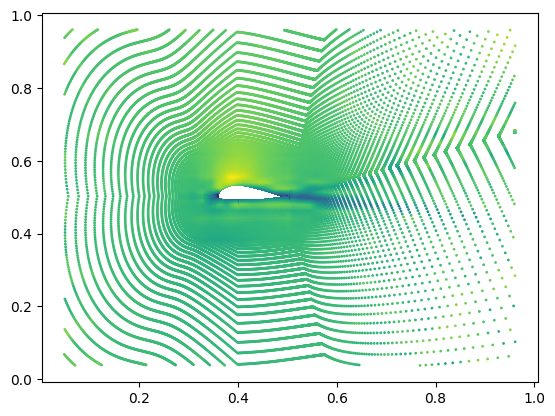

In [219]:
kk= 0
coordinates = graph.pos[graph.batch==kk]
pred = tinymodel(graph.pos[graph.batch==kk].cuda(), encoding_list[kk])
plt.scatter(coordinates[..., 0].detach().cpu(), coordinates[..., 1].detach().cpu(), c=pred.cpu().detach(), s=1)

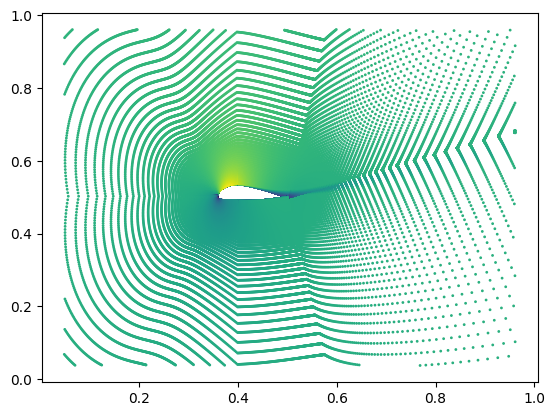

In [220]:
plt.scatter(coordinates[..., 0].detach().cpu(), coordinates[..., 1].detach().cpu(), c=graph.images[graph.batch==kk].cpu().detach(), s=1)

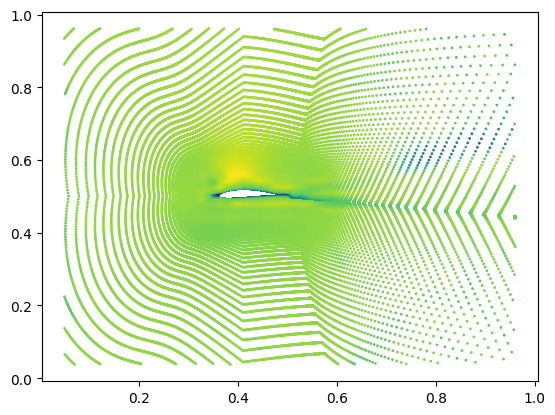

In [221]:
kk= 1
coordinates = graph.pos[graph.batch==kk]
pred = tinymodel(graph.pos[graph.batch==kk].cuda(), encoding_list[kk])
plt.scatter(coordinates[..., 0].detach().cpu(), coordinates[..., 1].detach().cpu(), c=pred.cpu().detach(), s=1)

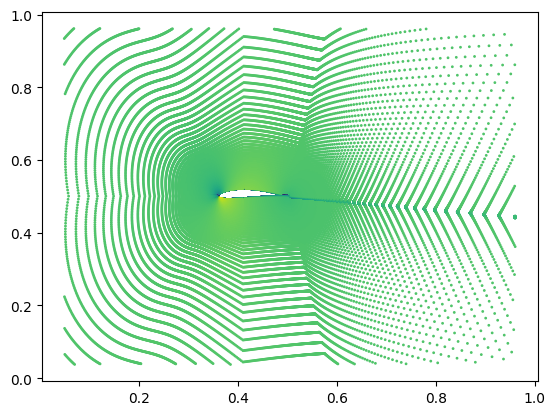

In [222]:
plt.scatter(coordinates[..., 0].detach().cpu(), coordinates[..., 1].detach().cpu(), c=graph.images[graph.batch==kk].cpu().detach(), s=1)

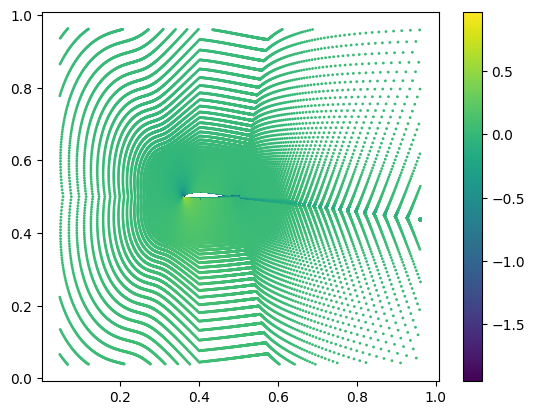

In [ ]:
plt.scatter(coordinates[..., 0].detach().cpu(), coordinates[..., 1].detach().cpu(), c=graph.images[graph.batch==kk].cpu().detach(), s=1)
plt.colorbar()

In [86]:
from collections import OrderedDict
from functools import partial

import einops
import coral.losses as losses
import torch
import torch.nn as nn
import torch.utils.checkpoint as cp
from torch import autograd
from torch.nn.parallel import DistributedDataParallel as DDP


def inner_loop(
    func_rep,
    decoding_list,
    coordinates,
    features,
    batch_index,
    n_samples,
    inner_steps,
    inner_lr,
    is_train=False,
    gradient_checkpointing=False,
    loss_type="mse",
):
    """Performs inner loop, i.e. fits modulations such that the function
    representation can match the target features.

    Args:
        func_rep (models.ModulatedSiren):
        modulations (torch.Tensor): Shape (batch_size, latent_dim).
        coordinates (torch.Tensor): Coordinates at which function representation
            should be evaluated. Shape (batch_size, *, coordinate_dim).
        features (torch.Tensor): Target features for model to match. Shape
            (batch_size, *, feature_dim).
        inner_steps (int): Number of inner loop steps to take.
        inner_lr (float): Learning rate for inner loop.
        is_train (bool):
        gradient_checkpointing (bool): If True uses gradient checkpointing. This
            can massively reduce memory consumption.
    """
    inner_sgd = torch.optim.SGD(itertools.chain(*[dec.parameters() for dec in decoding_list]), lr=inner_lr)
    
    for step in range(inner_steps):
        if gradient_checkpointing:
            decoding_list = cp.checkpoint(
                inner_loop_step,
                func_rep,
                decoding_list,
                coordinates,
                features,
                inner_sgd,
                torch.as_tensor(is_train),
                torch.as_tensor(gradient_checkpointing),
                loss_type,
            )
        else:
            decoding_list = inner_loop_step(
                func_rep,
                decoding_list,
                coordinates,
                features,
                batch_index,
                n_samples,
                inner_sgd,
                is_train,
                gradient_checkpointing,
                loss_type,
            )
    return decoding_list


def inner_loop_step(
    func_rep,
    decoding_list,
    coordinates,
    features,
    batch_index,
    n_samples,
    inner_sgd,
    is_train=False,
    gradient_checkpointing=False,
    loss_type="mse",
):
    """Performs a single inner loop step."""
    detach = not torch.is_grad_enabled() and gradient_checkpointing

    if loss_type == "mse":
        element_loss_fn = losses.per_element_mse_fn
    elif loss_type == "bce":
        element_loss_fn = losses.per_element_nll_fn
    elif "multiscale" in loss_type:
        loss_name = loss_type.split("-")[1]
        element_loss_fn = partial(
            losses.per_element_multi_scale_fn,
            loss_name=loss_name,
            last_element=False,
        )

    with torch.enable_grad():
        # Note we multiply by batch size here to undo the averaging across batch
        # elements from the MSE function. Indeed, each set of modulations is fit
        # independently and the size of the gradient should not depend on how
        # many elements are in the batch
        loss = 0
        for k in range(len(decoding_list)):
            crds = coordinates[batch_index==k]
            feats = features[batch_index==k]
            mask = torch.randperm(crds.shape[0])[:18000]
            features_recon = func_rep(crds[mask], decoding_list[k])
            loss += ((features_recon - feats[mask])**2).mean()    # f
        
        loss.backward(retain_graph=True)
        inner_sgd.step()
        # if clip_grad_value is not None:
        #    nn.utils.clip_grad_value_(grad, clip_grad_value)
    # Perform single gradient descent step
    
    return decoding_list


def outer_step(
    func_rep,
    graph,
    inner_steps,
    inner_lr,
    is_train=False,
    return_reconstructions=False,
    gradient_checkpointing=False,
    loss_type="mse",
    use_rel_loss=False,
):
    """

    Args:
        coordinates (torch.Tensor): Shape (batch_size, *, coordinate_dim). Note this
            _must_ have a batch dimension.
        features (torch.Tensor): Shape (batch_size, *, feature_dim). Note this _must_
            have a batch dimension.
    """

    if loss_type == "mse":
        loss_fn = torch.nn.MSELoss()
    elif loss_type == "bce":
        loss_fn = torch.nn.BCEWithLogitsLoss()
    func_rep.zero_grad()
    if isinstance(func_rep, DDP):
        func_rep = func_rep.module

    n_samples = len(graph)
    batch_index = graph.batch
    features = graph.images.clone()
    coordinates = graph.pos.clone()
    
    decoding_list = [tcnn.Network(32, 1, cfg_dict["network"]).cuda() for k in range(n_samples)]

    # Run inner loop
    decoding_list = inner_loop(
        func_rep,
        decoding_list,
        coordinates,
        features,
        batch_index,
        n_samples,
        inner_steps,
        inner_lr,
        is_train,
        gradient_checkpointing,
        loss_type,
    )
    per_example_loss = 0
    with torch.set_grad_enabled(is_train):
        for k in range(len(decoding_list)):
            crds = coordinates[graph.batch==k]
            feats = features[graph.batch==k]
            mask = torch.randperm(crds.shape[0])[:18000]
            features_recon = func_rep(crds[mask], decoding_list[k])
            per_example_loss += ((features_recon - feats[mask])**2).mean()  # features
            
        loss = per_example_loss / n_samples

    outputs = {
        "loss": loss,
        "psnr": losses.mse2psnr(per_example_loss).mean().item(),
        "decoding": decoding_list
    }

    if return_reconstructions:
        outputs["reconstructions"] = (
            features_recon[-1] if "multiscale" in loss_type else features_recon
        )

    if use_rel_loss:
        rel_loss = (
            losses.batch_mse_rel_fn(features_recon[-1], features).mean()
            if "multiscale" in loss_type
            else losses.batch_mse_rel_fn(features_recon, features).mean()
        )
        outputs["rel_loss"] = rel_loss

    return outputs


In [87]:
import itertools

In [88]:
with open('../config/tinycuda.yaml', 'r') as f:
    cfg = yaml.safe_load(f)
cfg = DictConfig(cfg)
cfg_dict = OmegaConf.to_container(cfg)

In [92]:
tinymodel = ModulatedDecoder(2, 1, cfg_dict).cuda()
optimizer = torch.optim.Adam(tinymodel.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, epochs //5, gamma=0.5)

In [93]:
for step in range(10000):
    train_loss = 0
    for graph, idx in train_loader:
        n_samples = len(graph)
        
        outputs = outer_step(tinymodel,
                            graph.cuda(),
                            3,
                            0.01,
                            is_train=True,
                            return_reconstructions=False,
                            gradient_checkpointing=False,
                            loss_type='mse',
                            use_rel_loss=False)
        loss = outputs['loss']
        optimizer.zero_grad()
        loss.backward(create_graph=False)
        optimizer.step()
        train_loss = loss.item()*n_samples
    if step%100==0:
        print('train_loss', step, train_loss / ntrain)
    

train_loss 0 0.9893671274185181
train_loss 100 0.8766882419586182
train_loss 200 0.7702465057373047
train_loss 300 0.5948439240455627
train_loss 400 0.6724250316619873
train_loss 500 0.8618783354759216
train_loss 600 0.856521725654602
train_loss 700 0.8457151651382446
train_loss 800 0.8217092156410217
train_loss 900 0.7761620283126831
train_loss 1000 0.7684911489486694
train_loss 1100 0.7923487424850464
train_loss 1200 0.6840311884880066
train_loss 1300 0.7064141035079956
train_loss 1400 0.7229322195053101
train_loss 1500 0.7337769269943237
train_loss 1600 0.7011265158653259
train_loss 1700 0.6961069107055664
train_loss 1800 0.680601954460144
train_loss 1900 0.6667883396148682
train_loss 2000 0.6474536657333374
train_loss 2100 0.6049498319625854
train_loss 2200 0.6409245729446411
train_loss 2300 0.6203242540359497
train_loss 2400 0.6155853867530823
train_loss 2500 0.6241388320922852
train_loss 2600 0.6058942675590515
train_loss 2700 0.6542993783950806
train_loss 2800 0.5738220810890198

In [94]:
outputs = outer_step(tinymodel,
                            graph.cuda(),
                            3,
                            0.01,
                            is_train=False,
                            return_reconstructions=False,
                            gradient_checkpointing=False,
                            loss_type='mse',
                            use_rel_loss=False)
print('outputs', outputs['loss'])

outputs tensor(0.4391, device='cuda:0')


In [95]:
decoding_list = outputs['decoding']

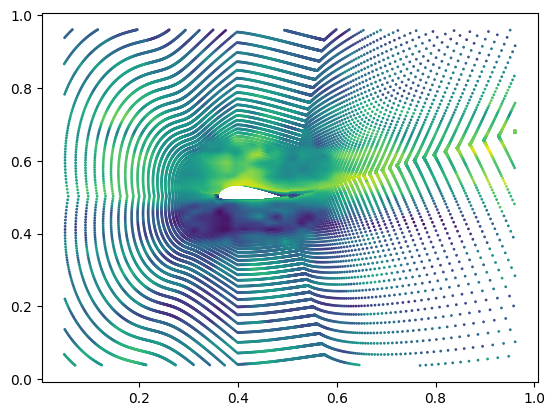

In [96]:
kk= 0
coordinates = graph.pos[graph.batch==kk]
pred = tinymodel(graph.pos[graph.batch==kk].cuda(), decoding_list[kk])
plt.scatter(coordinates[..., 0].detach().cpu(), coordinates[..., 1].detach().cpu(), c=pred.cpu().detach(), s=1)

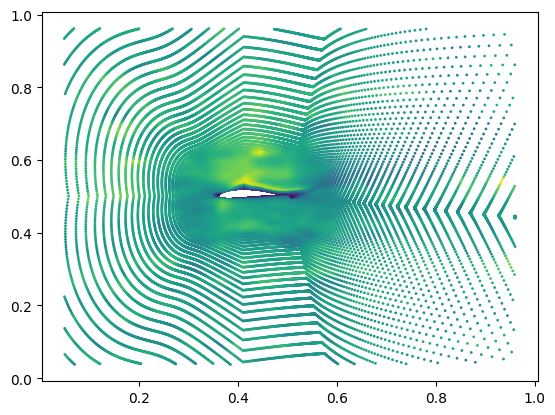

In [97]:
kk= 1
coordinates = graph.pos[graph.batch==kk]
pred = tinymodel(graph.pos[graph.batch==kk].cuda(), decoding_list[kk])
plt.scatter(coordinates[..., 0].detach().cpu(), coordinates[..., 1].detach().cpu(), c=pred.cpu().detach(), s=1)

In [201]:
encoding_list[0.params = nn.Parameter(torch.zeros_like(encoding_list[0].params))

In [203]:
encoding_list[0].params

Parameter containing:
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0', requires_grad=True)

In [ ]:
def oute

In [281]:
tinymodel(coordinates, encoding1)

tensor([[0.3101],
        [0.3101],
        [0.3098],
        ...,
        [0.3101],
        [0.3101],
        [0.3101]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SliceBackward0>)

In [264]:
encoding1 = tcnn.Encoding(2, cfg_dict["encoding"]).cuda()

In [270]:
encoding2 = tcnn.Encoding(2, cfg_dict["encoding"]).cuda()

In [273]:
encoding1(coordinates[-2:])

tensor([[ 7.7486e-06, -8.1658e-06, -1.8954e-05, -2.5034e-06,  1.5736e-05,
         -3.8862e-05, -2.8551e-05,  4.5300e-05],
        [ 6.9737e-06, -1.0252e-05, -8.5235e-06, -4.9472e-06,  1.9908e-05,
         -2.8193e-05, -2.6703e-05,  3.7313e-05]], device='cuda:0',
       dtype=torch.float16, grad_fn=<SliceBackward0>)

In [274]:
encoding2(coordinates[-2:])

tensor([[ 7.7486e-06, -8.1658e-06, -1.8954e-05, -2.5034e-06,  1.5736e-05,
         -3.8862e-05, -2.8551e-05,  4.5300e-05],
        [ 6.9737e-06, -1.0252e-05, -8.5235e-06, -4.9472e-06,  1.9908e-05,
         -2.8193e-05, -2.6703e-05,  3.7313e-05]], device='cuda:0',
       dtype=torch.float16, grad_fn=<SliceBackward0>)

In [185]:
4*2**4*2

128

In [110]:
128*128

16384

In [210]:
from copy import deepcopy

In [229]:
nef_clone = deepcopy(nef)
optimizer_clone = torch.optim.Adam(nef_clone.parameters(), lr=0.01)
optimizer_clone.load_state_dict(optimizer.state_dict())

In [230]:
for graph2, idx2 in train_loader:
    break

In [231]:
index = 0
mask = graph2.batch == index

In [232]:
gamma = 1
coordinates2 = graph2.pos[mask].cuda()
images2 = graph2.images[mask].cuda()
images_scaled2 = images2/gamma # images/ gamma

In [233]:
for step in range(100):
    mask = torch.randperm(coordinates2.shape[0])[:18000]
    pred = nef_clone(coordinates2[mask])
    loss = ((pred - images_scaled2[mask])**2).mean()
    optimizer_clone.zero_grad()
    loss.backward()
    optimizer_clone.step()
    scheduler.step()
    print(f"loss: {((pred*gamma - images2[mask])**2).mean()}")

loss: 43.31806182861328
loss: 42.1370964050293
loss: 38.867828369140625
loss: 32.53730010986328
loss: 29.447690963745117
loss: 25.307748794555664
loss: 19.41380500793457
loss: 16.879804611206055
loss: 14.727961540222168
loss: 11.80143928527832
loss: 10.029939651489258
loss: 8.404465675354004
loss: 6.449212074279785
loss: 5.262270927429199
loss: 4.476078987121582
loss: 3.465034246444702
loss: 2.7950916290283203
loss: 2.1117043495178223
loss: 1.6695256233215332
loss: 1.3020683526992798
loss: 0.9579570293426514
loss: 0.7886308431625366
loss: 0.6743971109390259
loss: 0.5224051475524902
loss: 0.43427857756614685
loss: 0.3724731504917145
loss: 0.33420005440711975
loss: 0.28612715005874634
loss: 0.2524595856666565
loss: 0.22077713906764984
loss: 0.21238762140274048
loss: 0.19158200919628143
loss: 0.18699055910110474
loss: 0.17989103496074677
loss: 0.17263257503509521
loss: 0.15991994738578796
loss: 0.15543535351753235
loss: 0.15104348957538605
loss: 0.14600788056850433
loss: 0.143523201346397

In [126]:
with open('../config/tinycuda.yaml', 'r') as f:
    cfg = yaml.safe_load(f)
cfg = DictConfig(cfg)
cfg_dict = OmegaConf.to_container(cfg)

In [127]:
encoding = tcnn.Encoding(2, cfg_dict["encoding"])

In [128]:
encoding.params.shape

torch.Size([1024])

In [36]:
class SimpleFrequency(nn.Module):
    def __init__(self, input_dim, output_dim, latent_dim=64, modulate_scale=False, modulate_shift=True):
        super().__init__()
        self.frequency = tcnn.Encoding(input_dim, {"otype": "Frequency", "n_frequencies": 8}, dtype=torch.float)
        mlp_config = {"otype": "CutlassMLP",     
         "activation": "None",      
        "output_activation": "ReLU", "n_neurons": 64, "n_hidden_layers": 0}
        
        mlp_config_out = {"otype": "CutlassMLP",     
         "activation": "None",      
        "output_activation": "None", "n_neurons": 64, "n_hidden_layers": 0}
        
        self.network1 = tcnn.Network(self.frequency.n_output_dims, 256, mlp_config)
        self.network2 = tcnn.Network(256, 256, mlp_config)
        self.network3 = tcnn.Network(256, 256, mlp_config)
        self.networkout = tcnn.Network(256, output_dim, mlp_config_out)
        
        self.bias1 = nn.Parameter(torch.zeros(256))
        self.bias2 = nn.Parameter(torch.zeros(256))
        self.bias3 = nn.Parameter(torch.zeros(256))
        self.biasout = nn.Parameter(torch.zeros(1))
        
        self.latent_to_modulation = tcnn.Network(128, 3*256, mlp_config_out)
        

    def modulated_forward(self, x, z):
        modulations = self.latent_to_modulation(z).reshape(-1, 256, 3)
        #position = self.frequency(x)
        position = self.frequency(x)
        #x = (1 + modulations[..., 0, 0] ) * self.network1(position) + modulations[..., 0, 1]  
        #x = (1 + modulations[..., 1, 0] ) * self.network2(x) + modulations[..., 1, 1]
        #x = (1 + modulations[..., 2, 0] ) * self.network3(x) + modulations[..., 2, 1]
        x = self.network1(position) + modulations[..., 0] + self.bias1
        x = self.network2(x) + modulations[..., 1] + self.bias2
        x = self.network3(x) + modulations[..., 2] + self.bias3
        out = self.networkout(x) + self.biasout
        return out

In [37]:
from graph_metalearning import outer_step

In [38]:
epochs = 10000
tinymodel = SimpleFrequency(2, 1).cuda()
optimizer = torch.optim.Adam(tinymodel.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, epochs //5, gamma=0.5)

In [39]:
for step in range(10000):
    train_loss = 0
    for graph, idx in train_loader:
        n_samples = len(graph)
        
        outputs = outer_step(tinymodel,
                            graph.cuda(),
                            3,
                            0.01,
                            is_train=True,
                            return_reconstructions=False,
                            gradient_checkpointing=False,
                            loss_type='mse',
                            use_rel_loss=False,
                            deta)
        
        loss = outputs['loss']
        optimizer.zero_grad()
        loss.backward(create_graph=False)
        optimizer.step()
        train_loss = loss.item()*n_samples
    if step%100==0:
        print('train_loss', step, train_loss / ntrain)
    

RuntimeError: DifferentiableObject::backward_backward_input_impl: not implemented error

In [37]:
dense_grid = shape2coordinates([256, 256]) * 0.5 + 0.4

In [42]:
dense_grid = dense_grid.cuda().flatten(0,1)

In [43]:
pred = nef(dense_grid)

In [44]:
pred = pred.cpu().detach()
dense_grid = dense_grid.cpu().detach()

In [46]:
pred.min()

tensor(-67.3750, dtype=torch.float16)

tensor([True, True, True,  ..., True, True, True])

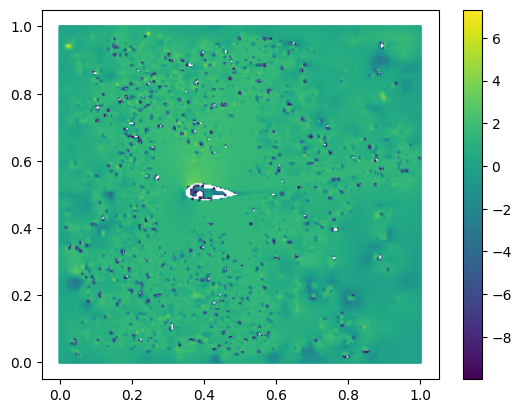

In [52]:
mask = (pred > -1).squeeze()
plt.scatter(dense_grid[mask, 0].detach().cpu(), dense_grid[mask, 1].detach().cpu(), c=gamma*pred[mask].cpu().detach(), s=1)
plt.colorbar()

In [36]:
# with sdf

In [38]:
gamma = 10
coordinates = torch.cat([graph.pos[mask], graph.x[2]], axis=-1)
images = graph.images[mask].cuda()
images_scaled = images/gamma # images/ gamma

TypeError: 'NoneType' object is not subscriptable

In [37]:
w0 = 30
inr = Siren(dim_in=3,
            dim_hidden=256,
            dim_out=1,
            num_layers=5,
            w0=w0,
            w0_initial=w0,
            use_bias=True,
        ).cuda()

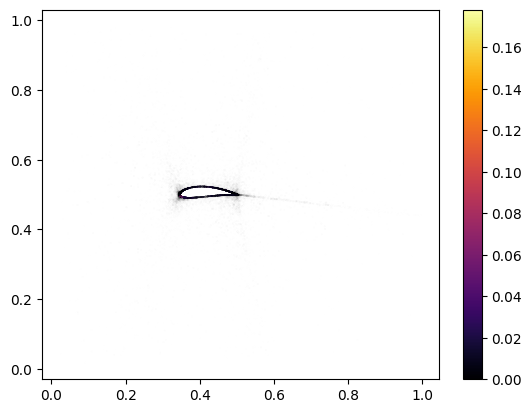

In [30]:
diff = ((gamma*pred - images)**2).cpu().detach()
plt.scatter(coordinates[..., 0].detach().cpu(), coordinates[..., 1].detach().cpu(), s=diff, c=diff, cmap='inferno')
plt.colorbar()

In [31]:
diff.mean()

tensor(0.0017)

In [32]:
mean_in, mean_out, std_in, std_out = trainset.coef_norm

In [33]:
std_in

array([ 4.1555424e+01,  8.7420683e+00, -2.4084377e+02,  7.6887710e-04],
      dtype=float32)

In [34]:
index_trained = idx[0]

In [35]:
graph_hr = dataset_list[index_trained]

NameError: name 'dataset_list' is not defined

In [183]:
pos_hr = torch.Tensor(graph_hr[..., :2])
pos_hr = (pos_hr - MIN_POS) / (MAX_POS - MIN_POS)

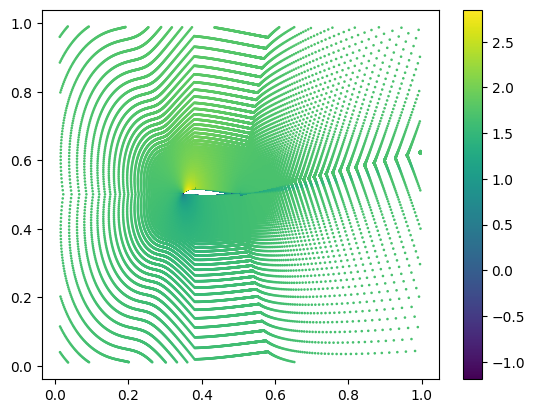

In [184]:
v_hr = (graph_hr[..., key_to_index['vx']] -mean_out[0] )/std_out[0]
plt.scatter(pos_hr[..., 0], pos_hr[..., 1], s=0.75, c= v_hr)
plt.colorbar()

In [185]:
pred_hr = inr(torch.Tensor(pos_hr).cuda()).cpu().detach()*gamma

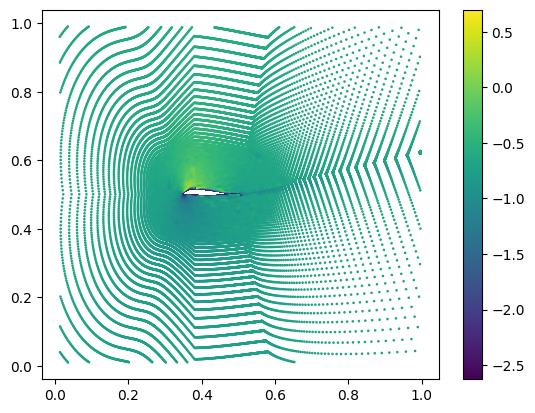

In [186]:
plt.scatter(pos_hr[..., 0], pos_hr[..., 1], s=0.75, c= pred_hr)
plt.colorbar()

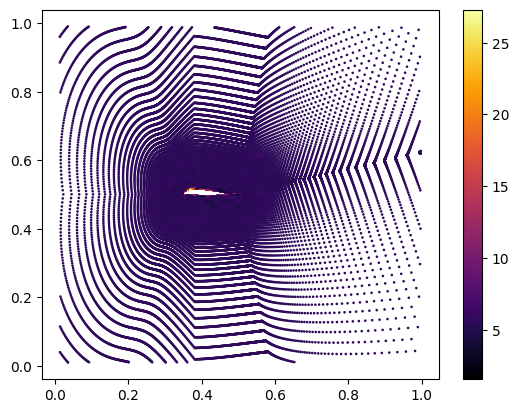

In [188]:
diff = ((pred_hr.detach().cpu().squeeze() - v_hr)**2)
plt.scatter(pos_hr[..., 0], pos_hr[..., 1], s=0.75, c= diff, cmap="inferno")
plt.colorbar()

# 3. With mesh sampling

In [191]:
trainset = manifest_train[:n] # was [:-n] ???
valset = manifest_train[n:]

In [194]:
#default sample is none
trainset2 = GeometryDataset(trainset, key=data_to_encode, latent_dim=latent_dim, norm=True, sample=None, n_boot=16000)
print("loaded train")
valset2 = GeometryDataset(valset, key=data_to_encode, latent_dim=latent_dim, sample=None, n_boot=16000, coef_norm=trainset2.coef_norm)

train_loader2 = DataLoader(trainset2, batch_size=batch_size, shuffle=True)
# test
val_loader2 = DataLoader(valset2, batch_size=batch_size_val, shuffle=True)
device = torch.device("cuda")

100%|████████████████████████████████████████████████████████████████████████████████| 720/720 [04:24<00:00,  2.72it/s]


coef_norm (array([ 5.0067395e-01,  1.1246346e-02,  6.1503807e+01,  4.8500433e+00,
        2.3172970e-01, -1.6548282e-03, -8.6467640e-05], dtype=float32), array([ 0.7040369 ,  0.3364    , 17.780106  ,  6.284955  ,  0.4752076 ,
        0.04153645,  0.06240817], dtype=float32), array([ 4.2436943e+01,  9.6964874e+00, -4.5236975e+02,  7.9545029e-04],
      dtype=float32), array([2.9641506e+01, 3.0877468e+01, 2.9632727e+03, 2.9404047e-03],
      dtype=float32))
loaded train


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:30<00:00,  2.66it/s]


coef_norm (array([ 5.0067395e-01,  1.1246346e-02,  6.1503807e+01,  4.8500433e+00,
        2.3172970e-01, -1.6548282e-03, -8.6467640e-05], dtype=float32), array([ 0.7040369 ,  0.3364    , 17.780106  ,  6.284955  ,  0.4752076 ,
        0.04153645,  0.06240817], dtype=float32), array([ 4.2436943e+01,  9.6964874e+00, -4.5236975e+02,  7.9545029e-04],
      dtype=float32), array([2.9641506e+01, 3.0877468e+01, 2.9632727e+03, 2.9404047e-03],
      dtype=float32))


In [276]:
w0 = 30
inr = Siren(dim_in=2,
            dim_hidden=256,
            dim_out=1,
            num_layers=5,
            w0=w0,
            w0_initial=w0,
            use_bias=True,
        ).cuda()

In [277]:
optimizer = torch.optim.Adam(inr.parameters(), lr=1e-4)

In [278]:
for graph, idx in train_loader2:
    break

In [279]:
index = 0
mask = graph.batch == index

In [280]:
gamma = 10
coordinates = graph.pos[mask].cuda()
images = graph.images[mask].cuda()
images_scaled = images/gamma # images/ gamma

In [281]:
coords_sub = coordinates[::10]
images_sub = images_scaled[::10]

In [282]:
images_sub.shape

torch.Size([16028, 1])

In [283]:
pred.shape

torch.Size([17950, 1])

In [284]:
epochs=10000
for step in range(epochs):
    pred = inr(coords_sub)
    loss = ((pred - images_sub)**2).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if step % 200 == 0:
        print(f"loss: {((gamma*(pred - images_sub))**2).mean()}")

loss: 1.617484211921692
loss: 0.18210963904857635
loss: 0.23343124985694885
loss: 0.1408294141292572
loss: 0.12923815846443176
loss: 0.17769351601600647
loss: 0.1420958936214447
loss: 0.11587870866060257
loss: 0.10722023993730545
loss: 0.12579309940338135
loss: 0.20803788304328918
loss: 0.1054709255695343
loss: 0.2015542834997177
loss: 0.08223389089107513
loss: 0.08908189833164215
loss: 0.1095796599984169
loss: 0.11075668036937714
loss: 0.09244582802057266
loss: 0.15665967762470245
loss: 0.0776786357164383
loss: 0.09610281139612198
loss: 0.08589402586221695
loss: 0.078227698802948
loss: 0.096023328602314
loss: 0.08573851734399796
loss: 0.08980237692594528
loss: 0.09794095903635025
loss: 0.0983344167470932
loss: 0.12227803468704224
loss: 0.0721668154001236
loss: 0.11731236428022385
loss: 0.09404091536998749
loss: 0.07896041125059128
loss: 0.0675535574555397
loss: 0.07446419447660446
loss: 0.07357921451330185
loss: 0.08298853784799576
loss: 0.10299757122993469
loss: 0.07567496597766876
l

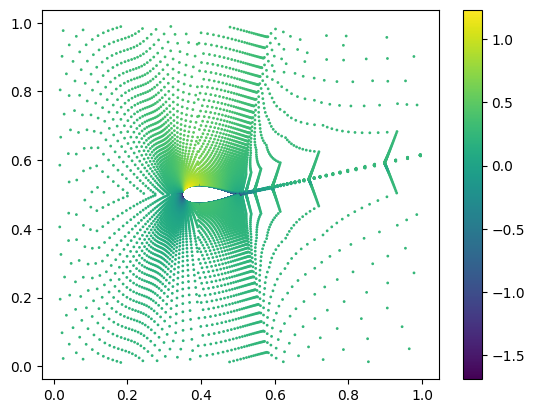

In [273]:
plt.scatter(coords_sub[..., 0].detach().cpu(), coords_sub[..., 1].detach().cpu(), c=gamma*images_sub.detach().cpu(), s=1)
plt.colorbar()

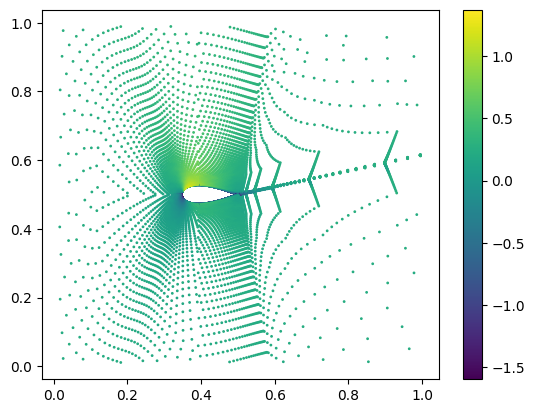

In [274]:
plt.scatter(coords_sub[..., 0].detach().cpu(), coords_sub[..., 1].detach().cpu(), c=gamma*pred.detach().cpu(), s=1)
plt.colorbar()

In [321]:
w0 = 30
inr = Siren(dim_in=2,
            dim_hidden=256,
            dim_out=1,
            num_layers=5,
            w0=w0,
            w0_initial=w0,
            use_bias=True,
        ).cuda()

In [322]:
optimizer = torch.optim.Adam(inr.parameters(), lr=1e-4)

In [323]:
x_mask = (coordinates[..., 0] < 0.6) & (coordinates[..., 0] > 0.4)
y_mask = (coordinates[..., 1] < 0.6) & (coordinates[..., 1] > 0.4)
mask = x_mask & y_mask

In [324]:
coords_sub = (coordinates[mask] - 0.4)*100
images_sub = images_scaled[mask]

In [325]:
epochs=10000
for step in range(epochs):
    pred = inr(coords_sub)
    loss = ((pred - images_sub)**2).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if step % 200 == 0:
        print(f"loss: {((gamma*(pred - images_sub))**2).mean()}")

loss: 1.034475564956665
loss: 0.013061603531241417
loss: 0.007928073406219482
loss: 0.004260915331542492
loss: 0.0032179937697947025
loss: 0.0033631008118391037
loss: 0.0023756169248372316
loss: 0.0017124955775216222
loss: 0.0019903641659766436
loss: 0.002891495358198881
loss: 0.0009753579506650567
loss: 0.0012166238157078624
loss: 0.0012091930257156491
loss: 0.001270992448553443
loss: 0.0014312054263427854
loss: 0.0009011279908008873
loss: 0.0018298239447176456
loss: 0.0017821554793044925
loss: 0.0006422006990760565
loss: 0.0006973950075916946
loss: 0.0013524823589250445
loss: 0.00138726772274822
loss: 0.0014934593345969915
loss: 0.0012435703538358212
loss: 0.0017909595044329762
loss: 0.0014233742840588093
loss: 0.0013678964460268617
loss: 0.0006341334083117545
loss: 0.0009100615861825645
loss: 0.000862468674313277
loss: 0.0013830516254529357
loss: 0.0015914434334263206
loss: 0.0013916543684899807
loss: 0.00035944324918091297
loss: 0.0005034864880144596
loss: 0.0008461619727313519
los

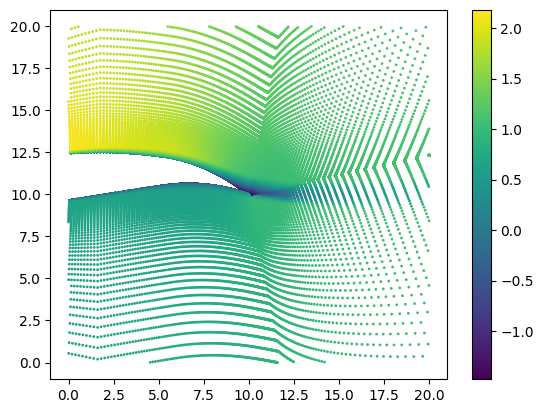

In [326]:
plt.scatter(coords_sub[..., 0].detach().cpu(), coords_sub[..., 1].detach().cpu(), c=gamma*images_sub.detach().cpu(), s=1)
plt.colorbar()

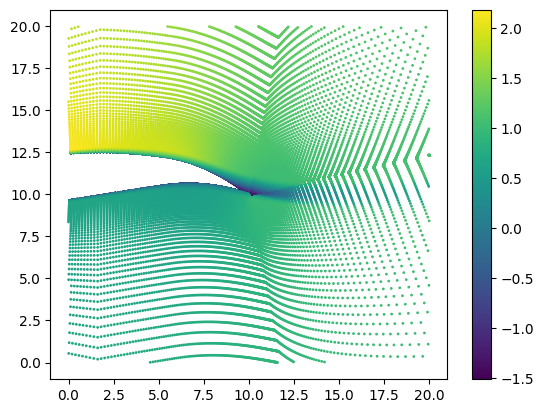

In [327]:
plt.scatter(coords_sub[..., 0].detach().cpu(), coords_sub[..., 1].detach().cpu(), c=gamma*pred.detach().cpu(), s=1)
plt.colorbar()

In [ ]:
coord_plt

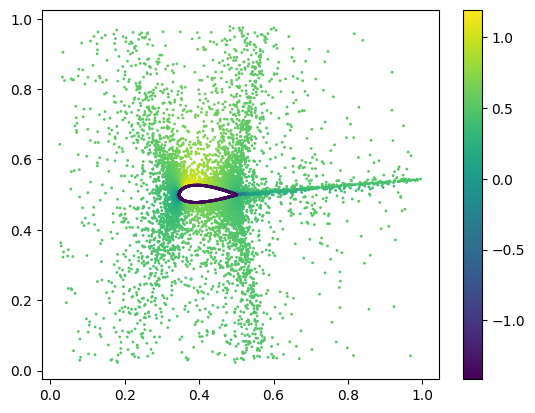

In [128]:
img_plt = images.detach().cpu()
pred_plt = pred.detach().cpu()
coord_plt = coordinates.detach().cpu()
plt.scatter(coord_plt[..., 0], coord_plt[..., 1], c=img_plt, s=1)
plt.colorbar()

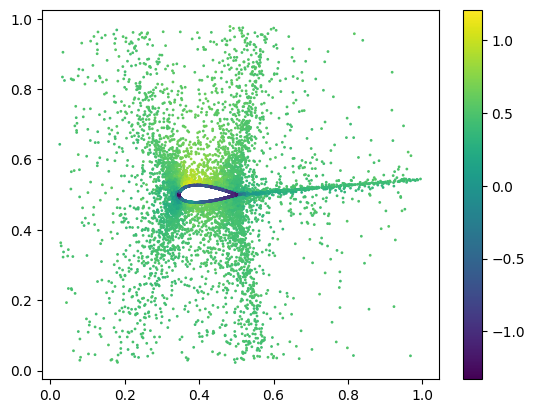

In [129]:
plt.scatter(coord_plt[..., 0], coord_plt[..., 1], c=pred_plt*gamma, s=1)
plt.colorbar()

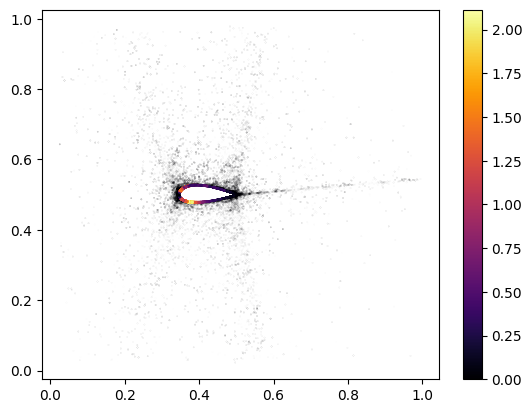

In [130]:
plt.scatter(coord_plt[..., 0], coord_plt[..., 1], c=(pred_plt*gamma-img_plt)**2, s=(pred_plt*gamma-img_plt)**2, cmap="inferno")
plt.colorbar()

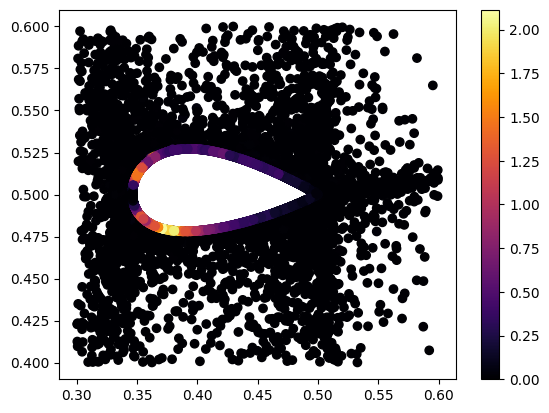

In [134]:
x_mask = (coord_plt[..., 0] < 0.6) & (coord_plt[..., 0] > 0.3)
y_mask = (coord_plt[..., 1] < 0.6) & (coord_plt[..., 1] > 0.4)
plot_mask = x_mask & y_mask
plt.scatter(coord_plt[plot_mask, 0], coord_plt[plot_mask, 1], c=((pred_plt*gamma-img_plt)**2)[plot_mask], cmap="inferno")
plt.colorbar()

In [184]:
from sklearn.cluster import KMeans

In [187]:
clustering_model = KMeans(n_clusters=128, init='k-means++', n_init='warn', max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='lloyd')

In [ ]:
clustering_model.fit(gr